In [1]:
from asyncio.windows_events import NULL
import os
from PIL.Image import ID
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import PlottingFunctions as pf
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm
from time import perf_counter
# %matplotlib widget

In [2]:
def load_object(filename):
    '''
    load an object from a file using the built-in pickle library

    :param filename: Name of the file from which to load data
    '''
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

In [66]:
def XYZoverTime(pos_r, pos_i, pos_p):
    plt.rcParams["figure.figsize"] = (14,10)
    plt.subplot(3,1,1)
    plt.plot(pos_r[:,0], 'b-', label='real')
    plt.plot(pos_i[:,0], 'r--', label='integral')
    plt.plot(pos_p[:,0], 'g,', label='prediction')
    plt.legend()
    plt.ylabel('X')
    plt.grid()
    plt.subplot(3,1,2)
    plt.plot(pos_r[:,1], 'b-', label='real')
    plt.plot(pos_i[:,1], 'r--', label='integral')
    plt.plot(pos_p[:,1], 'g,', label='prediction')
    plt.legend()
    plt.ylabel('Y')
    plt.grid()
    plt.subplot(3,1,3)
    plt.plot(pos_r[:,2], 'b-', label='real')
    plt.plot(pos_i[:,2], 'r--', label='integral')
    plt.plot(pos_p[:,2], 'g,', label='prediction')
    plt.legend()
    plt.ylabel('Z')
    plt.xlabel('t')
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_rolling_timeseries_stats(real, predictions, window_size=200):
    """
    Plot time series for x, y, z coordinates with rolling mean and standard deviation.
    
    Parameters:
    - predictions: NumPy array of shape (n_timesteps, 3)
    - window_size: Size of the rolling window for calculating mean and std dev
    """
    # Create a figure with 3 subplots (one for each coordinate)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    coordinates = ['X', 'Y', 'Z']
    
    for i in range(3):
        # Extract the i-th coordinate
        coord_data = predictions[:, i]
        
        # Calculate rolling mean and standard deviation using pandas-like method
        rolling_mean = np.zeros_like(coord_data)
        rolling_std = np.zeros_like(coord_data)
        
        for j in range(len(coord_data)):
            # Determine the window boundaries
            start = max(0, j - window_size // 2)
            end = min(len(coord_data), j + window_size // 2)
            
            # Calculate local statistics
            window_data = coord_data[start:end]
            rolling_mean[j] = np.mean(window_data)
            rolling_std[j] = np.std(window_data)
        
        # Plot the original time series
        axes[i].plot(np.arange(len(coord_data)), coord_data, 'g,', label='Predictions')
        axes[i].plot(np.arange(len(coord_data)), real[:, i], 'r-', label='Actual')
        
        
        # Plot the rolling mean line
        axes[i].plot(np.arange(len(coord_data)), rolling_mean, color='blue', linestyle='--', 
                     label=f'Rolling Mean (window={window_size})')
        
        # Add rolling standard deviation shading
        axes[i].fill_between(np.arange(len(coord_data)), 
                             rolling_mean - rolling_std, 
                             rolling_mean + rolling_std, 
                             color='cyan', alpha=0.4, 
                             label='±1 std dev')
        
        # Customize the plot
        axes[i].set_title(f'{coordinates[i]} Coordinate Time Series')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.7)
    
    axes[-1].set_xlabel('Time Steps')
    plt.tight_layout()
    plt.show()

def prediction_path_projected(path, path_pred, mse, ID=0):
    stop = int(len(path))
    stop = np.clip(stop, 10, 40000)
    
    x, y, z = path[:,0], path[:,1], path[:,2] 
    x_pred, y_pred, z_pred = path_pred[:,0], path_pred[:,1], path_pred[:,2] 
    x_min, y_min, z_min = np.min(x), np.max(y), np.min(z) # the y-axis is weird like that

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot x and y axes on z.
    ax.plot(x[:stop], y[:stop], 'b-', zs=z_min, zdir='z', label='path in (x, y)')
    ax.plot(x_pred[:stop], y_pred[:stop], 'c,', zs=z_min, zdir='z', label='prediction in (x, y)')
    
    ax.plot(x[:stop], z[:stop], 'r-', zs=y_min, zdir='y', label='path in (x, z)')
    ax.plot(x_pred[:stop], z_pred[:stop], 'm,' ,zs=y_min, zdir='y', label='prediction in (x, z)')
    
    ax.plot(y[:stop], z[:stop], 'g-', zs=x_min, zdir='x', label='path in (y, z)')
    ax.plot(y_pred[:stop], z_pred[:stop], 'y,', zs=x_min, zdir='x', label='prediction in (y, z)')

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Integrated vs Predicted Path. First {stop} iterations. Mean MSE = {np.mean(mse)}')
    
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #ax.view_init(elev=20., azim=-35, roll=0)
    plt.tight_layout()
    # Save and show the figure
    plt.show()
    plt.savefig(f'Results\\ID {ID}\\predictionProjected.png', format='png')
    plt.close()

## Load Data and Prepare

In [62]:
name = 'FindGains3D' #'MovementCheck3D'
filename = f'Results\\ID {name}\\Data {name}.pickle'
data = load_object(filename)

online = data['online'] # simulation was online prediction
ID = data['name'] # name of the simulation
boundaries = data['boundaries']
minutes = data['sim time']
dt = data['dt ms'] # in ms
gains = np.array(data['gains']) # list of gains that every network uses
projection = np.array(data['modular projections']) # bool of the dim each module projects
projection_operator = np.array(data['module operators']) # operator used to project 3d data to modules
noise = data['noise']
vel = np.array(data['velocity'])
pos_r = np.array(data['position']) # real position
pos_i = np.array(data['position internal']) # integrator position
pos_p = np.array(data['position prediction']) # predicted position
activity = np.array(data['activity']) # neural network activity 

if online:
    mse_ar = np.array(data['predicted mse']) # mse online
else:
    mse_sc = data['mse'] # scalar mse mean offline
    mse_sh = data['mse_shuffeled'] # scalar mse shuffeled offline
    r2 = data['r2_mean'] # scalar r2 score offline
    r2_sh = data['r2_shuffeled'] # scalar r2 shuffeled offline

In [63]:
print(f'''Simulation was run with {'online' if online else 'offline'} prediction.
Name : {ID}
Minutes simulated : {minutes}
Gains used by 2d modules: {gains}
Amount of modules used : {len(projection)}
Projection of the modules by module and dimension : \n{projection}
Timestep dt of the simulation in ms : {dt}''')

print(f"gains shape: {gains.shape}")
print(f"projection_operator shape: {projection_operator.shape}")
print(f"activity shape: {activity.shape}")
print(f"pos_r shape: {pos_r.shape}")

if online:
    print(f"pos_i shape: {pos_i.shape}")
    print(f"pos_p shape: {pos_p.shape}")
    print(f"mse_ar shape: {mse_ar.shape}")
else:
    print(f"mse_scalar: {type(mse_sc)}, value: {mse_sc}")
    print(f"mse_shuffeled: {type(mse_sh)}, value: {mse_sh}")
    print(f"r2: {type(r2)}, value: {r2}")
    print(f"r2_shuffeled: {type(r2_sh)}, value: {r2_sh}")

Simulation was run with online prediction.
Name : FindGains3D
Minutes simulated : 10.0
Gains used by 2d modules: [0.2 0.4 0.6 0.8 1. ]
Amount of modules used : 2
Projection of the modules by module and dimension : 
[[ True  True False]
 [False  True  True]]
Timestep dt of the simulation in ms : 32
gains shape: (5,)
projection_operator shape: (2, 2, 3)
activity shape: (18564, 2, 5, 90)
pos_r shape: (18564, 3)
pos_i shape: (18564, 3)
pos_p shape: (18564, 3)
mse_ar shape: (18564, 3)


Simulation data
 Using gains:[0.2 0.4 0.6 0.8 1. ]


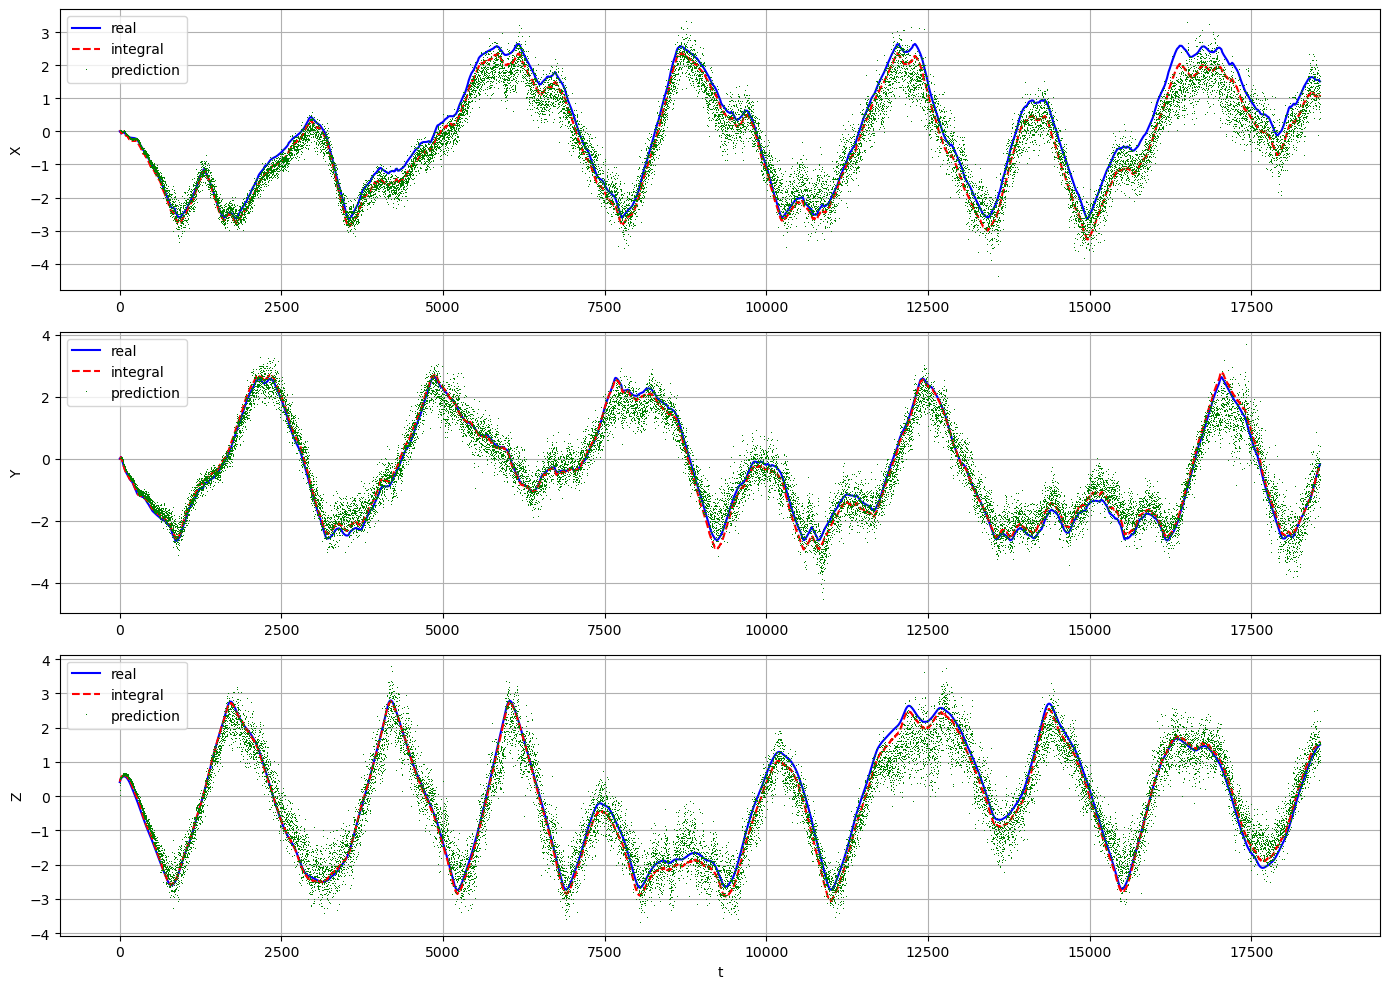

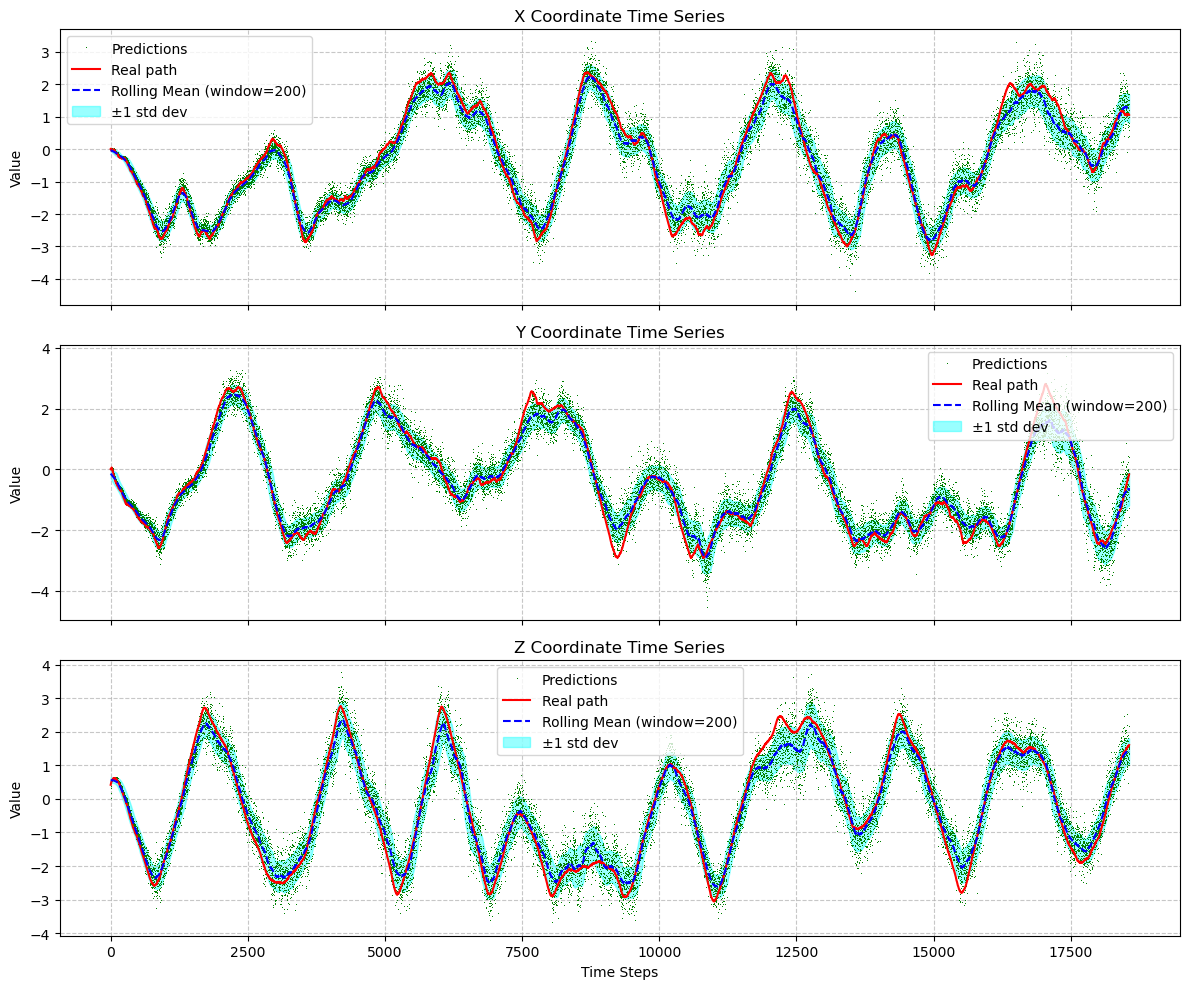

In [65]:
print(f'Simulation data\n Using gains:{gains}')
XYZoverTime(pos_r, pos_i, pos_p)
plot_rolling_timeseries_stats(pos_i, pos_p)

# Reconstruct result from data

In [67]:
from PredictionModel import OptimisedRLS
from optimisedGridNetwork import MixedModularCoder
gains = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
mmc = MixedModularCoder(gains=gains)
mmc.set_integrator(pos_r[0])
rls = OptimisedRLS(mmc.ac_size, num_outputs=3)
act_log = []
pos_log = []
pred_log = []
error_log = []
dt = (32/1000)
nn, vn = noise
for ind, v in enumerate(tqdm(vel)):
    #t1 = perf_counter() 
    act, pos = mmc.update(dt* (v + np.random.normal(scale=vn)))
    #t2 = perf_counter() 
    act_n = np.random.normal(0, nn, np.shape(act))
    noisy_activity = np.clip(act + act_n, 0.0, 1.0)
    
    act_log.append(noisy_activity.copy())
    pos_log.append(pos.copy())
    pos_prediction = rls.predict(noisy_activity)
    #t3 = perf_counter()
    pos_error = (pos-pos_prediction)**2
    rls.update(noisy_activity, pos)
    #t4 = perf_counter()
    pred_log.append(pos_prediction.copy())
    error_log.append(pos_error)

    #if(ind % 1000 == 0):
    #    print(f'Time for execution:\n MMC update:{t2-t1}\n rls prediction:{t3-t2}\n rls update:{t4-t3}')
    
#X, y, y_pred, mse_mean, mse_shuffeled, r2_mean, r2_shuffeled = fit_linear_model(np.array(act_log), pos_i, return_shuffled=True)
mse = np.mean(pred_log)
y_pred = np.array(pred_log)
y = np.array(pos_log)

Distance matrix initialized
Distance matrix initialized
Initialised Mixed Modular Coder


  0%|          | 0/18564 [00:00<?, ?it/s]

using gains: [0.2 0.4 0.6 0.8 1. ]
 mse_mean = -0.051422156876072586


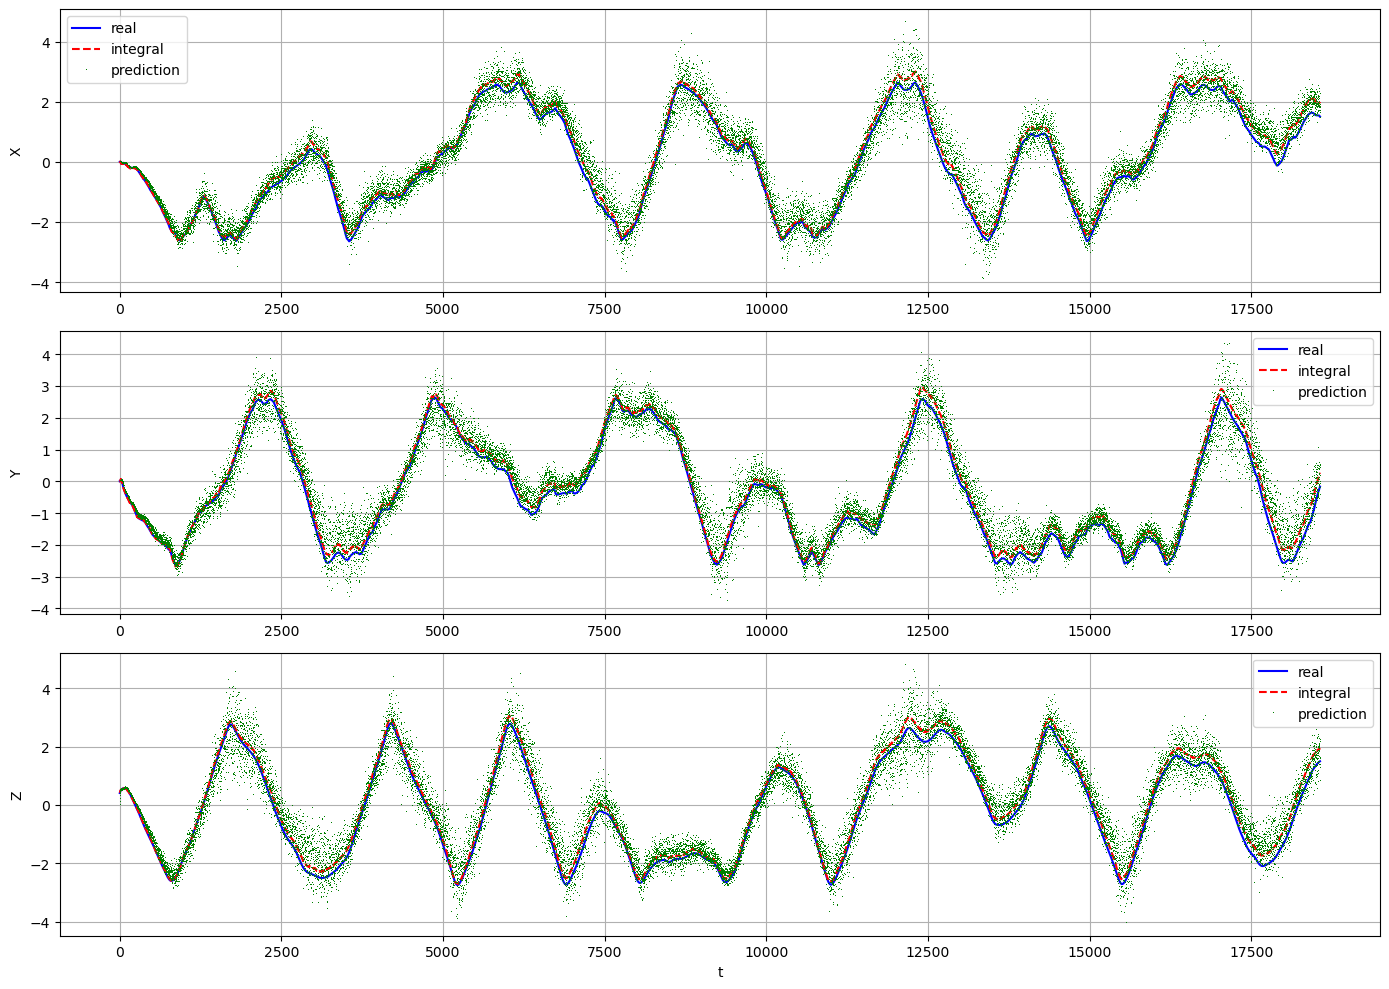

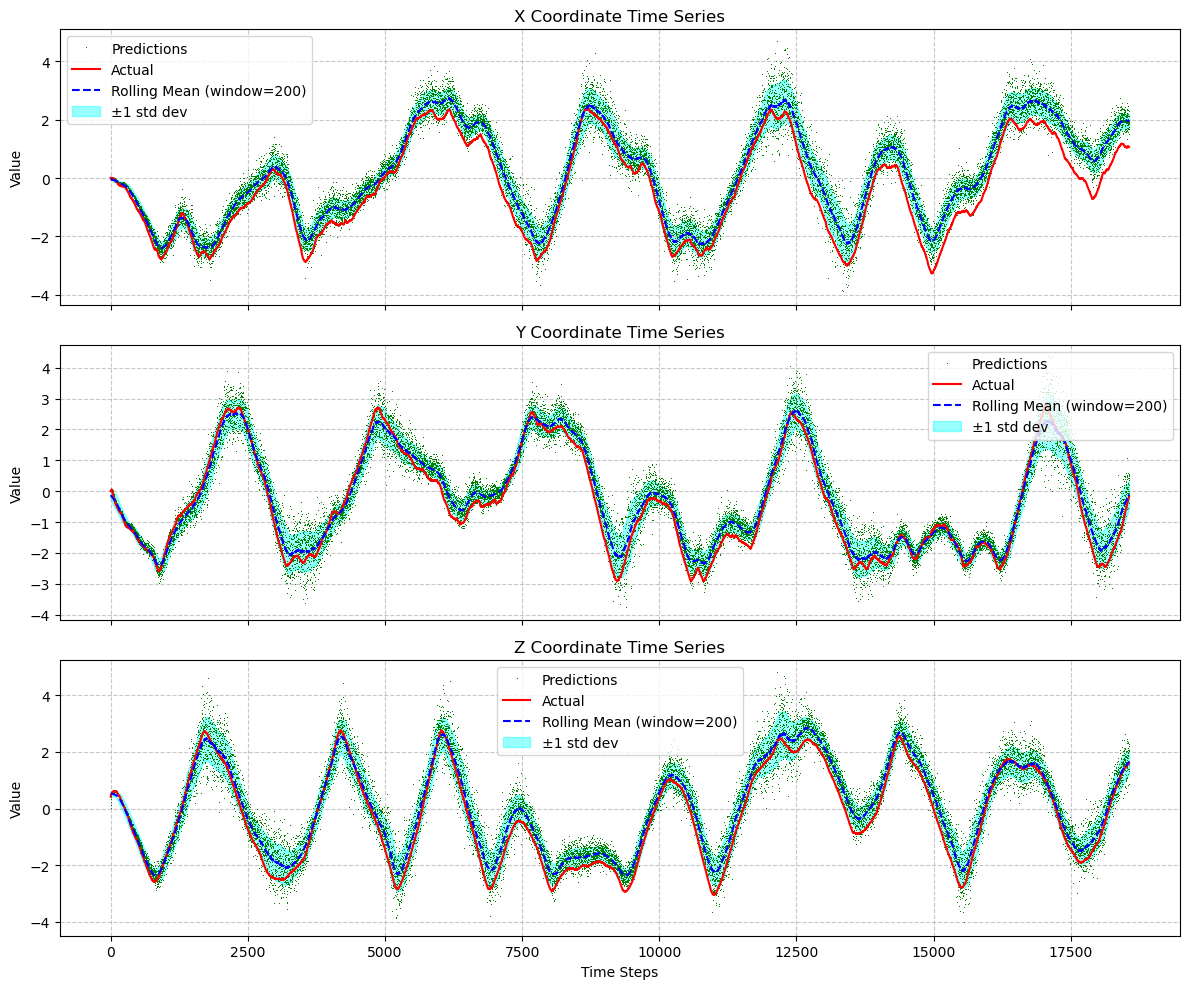

In [69]:
print(f'using gains: {gains}\n mse_mean = {mse}')
XYZoverTime(pos_r, y, pos_p=y_pred)
plot_rolling_timeseries_stats(pos_i, y_pred)

# Loop over gains

Distance matrix initialized
Distance matrix initialized
Initialised Mixed Modular Coder


  0%|          | 0/18564 [00:00<?, ?it/s]

using 3 gains with range 1.0 results: [0.2 0.6 1. ]
 mse_mean = -0.306755889023639


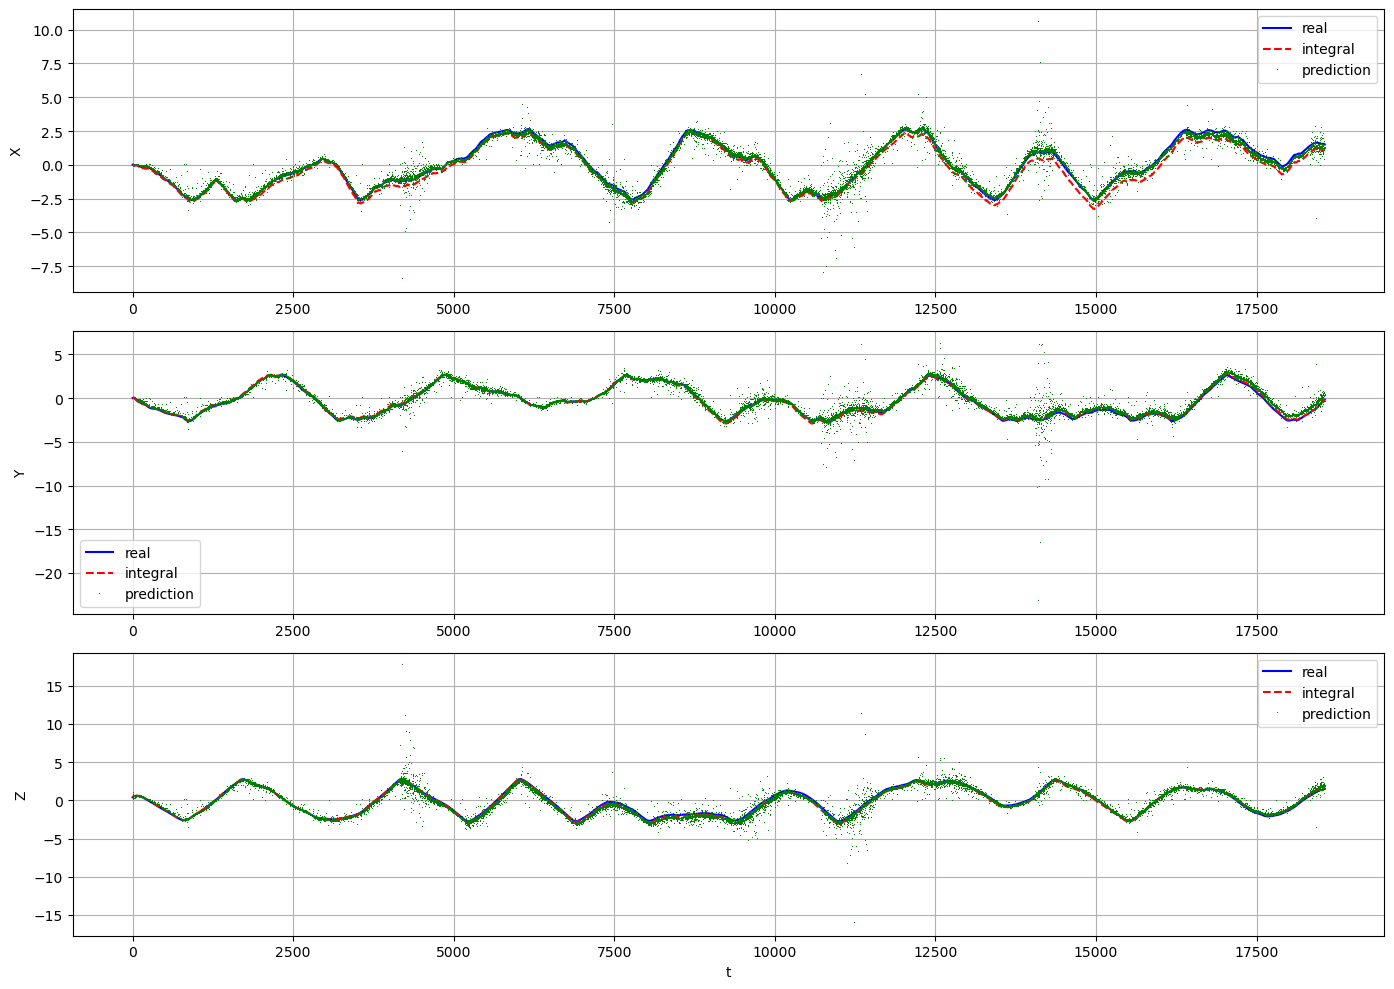

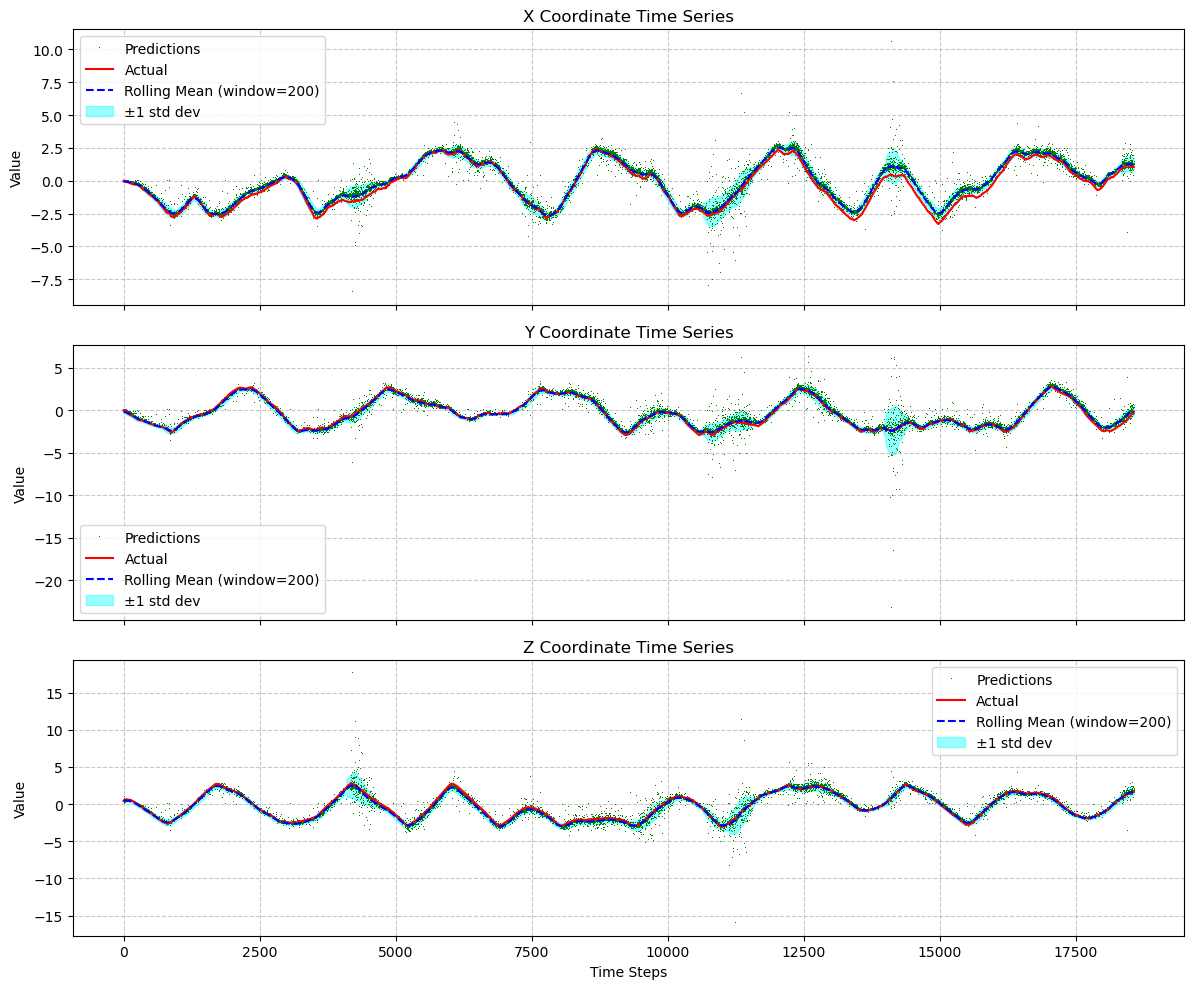

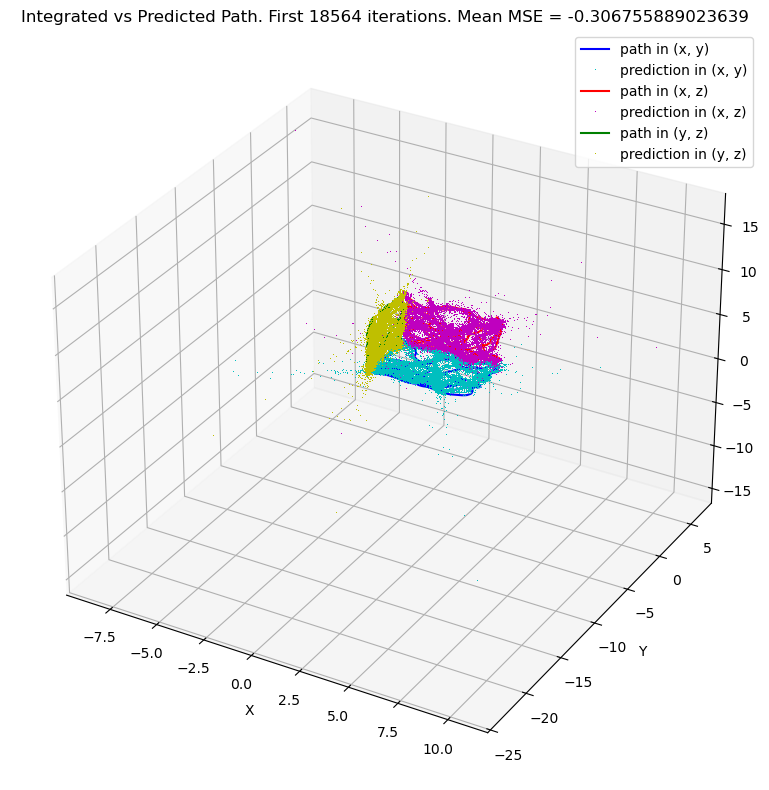

Distance matrix initialized
Distance matrix initialized
Initialised Mixed Modular Coder


  0%|          | 0/18564 [00:00<?, ?it/s]

using 3 gains with range 1.5 results: [0.2  0.85 1.5 ]
 mse_mean = -0.3073543143800708


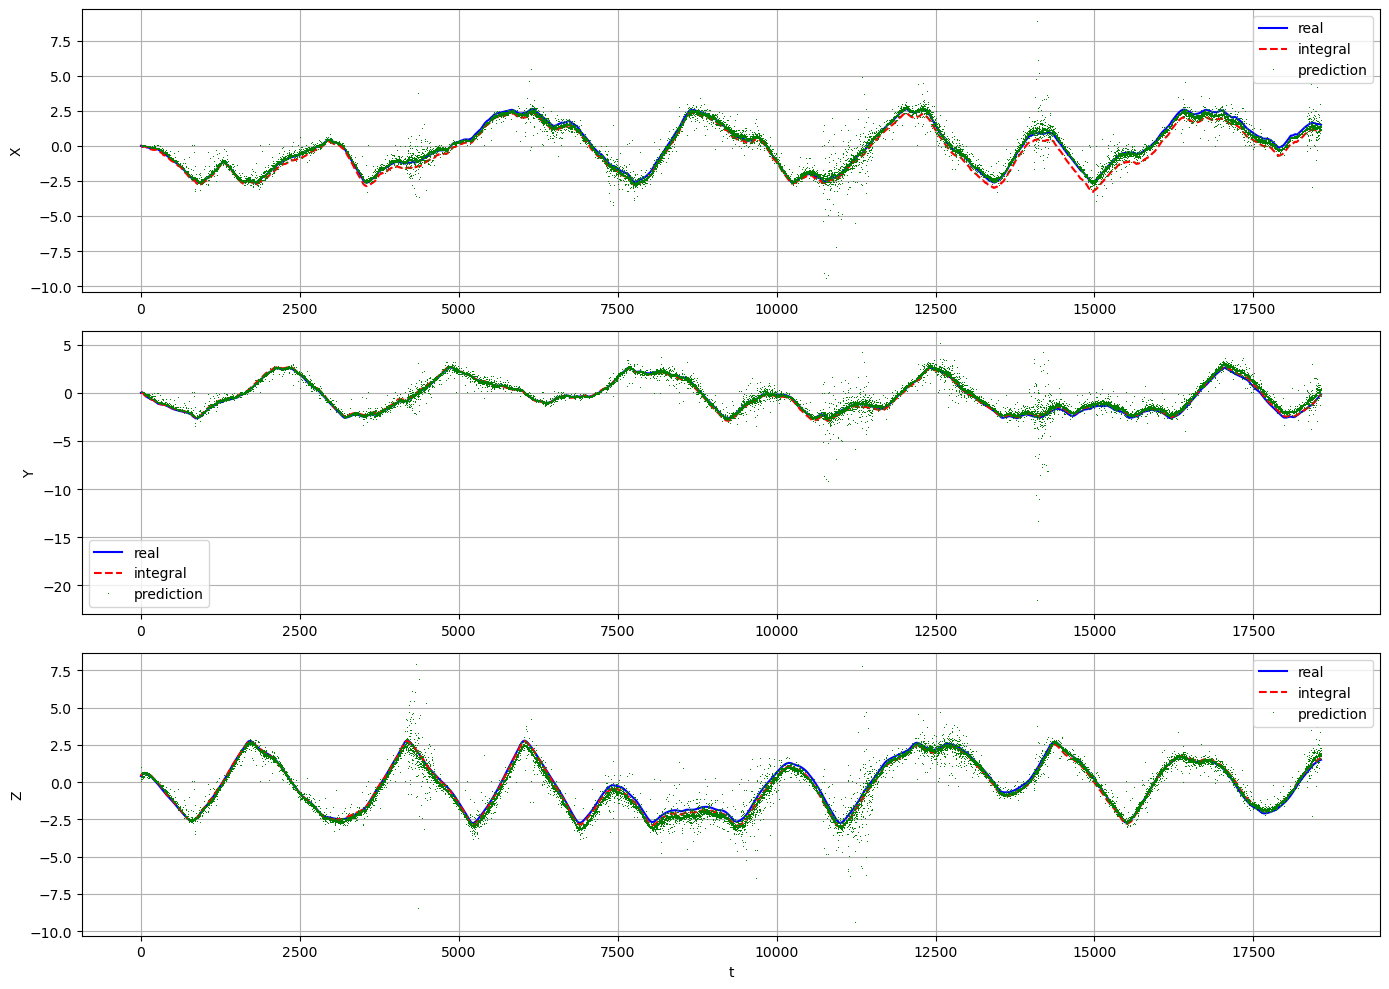

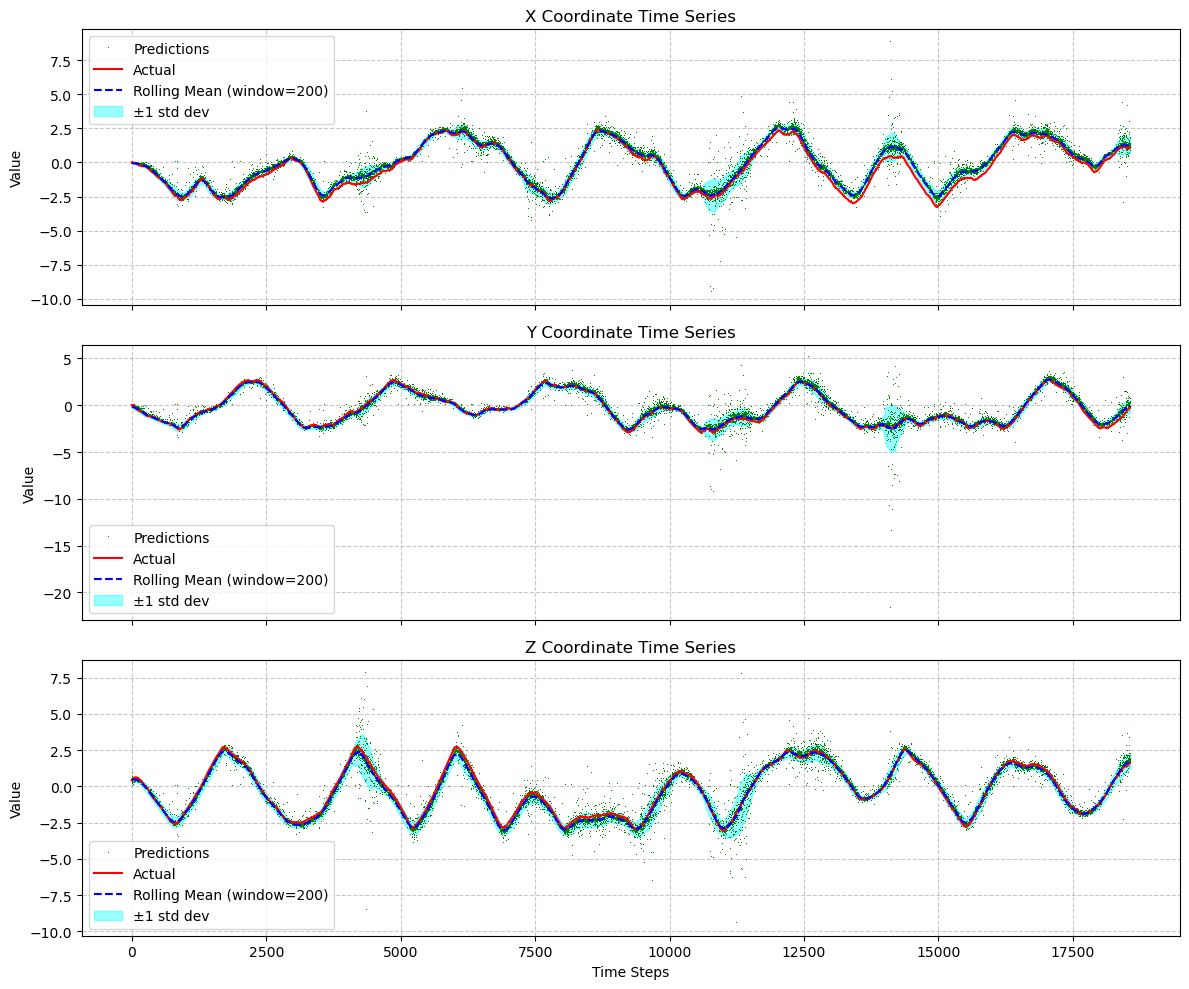

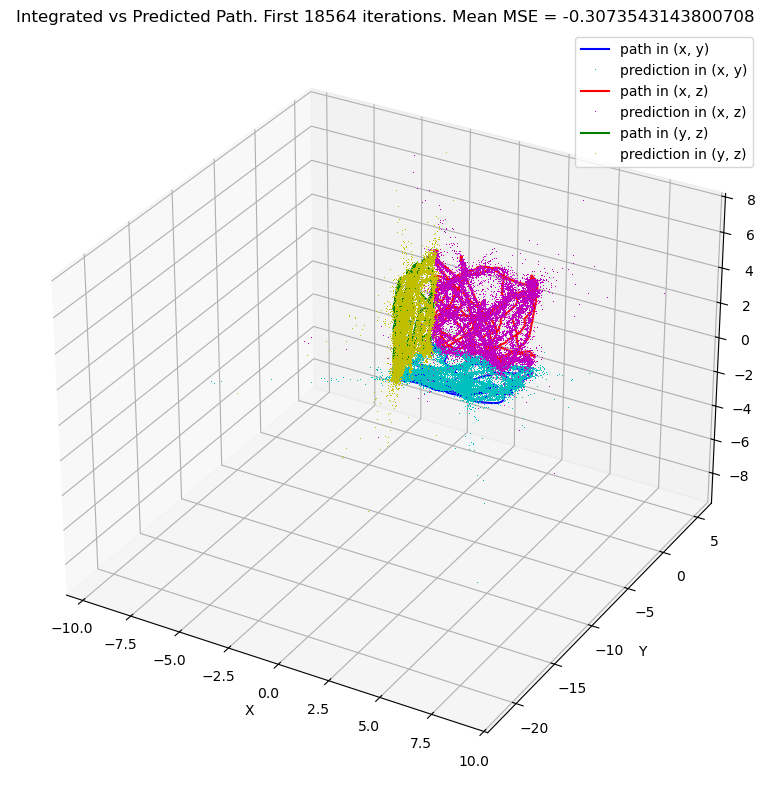

Distance matrix initialized
Distance matrix initialized
Initialised Mixed Modular Coder


  0%|          | 0/18564 [00:00<?, ?it/s]

using 3 gains with range 2.0 results: [0.2 1.1 2. ]
 mse_mean = -0.3064080285683972


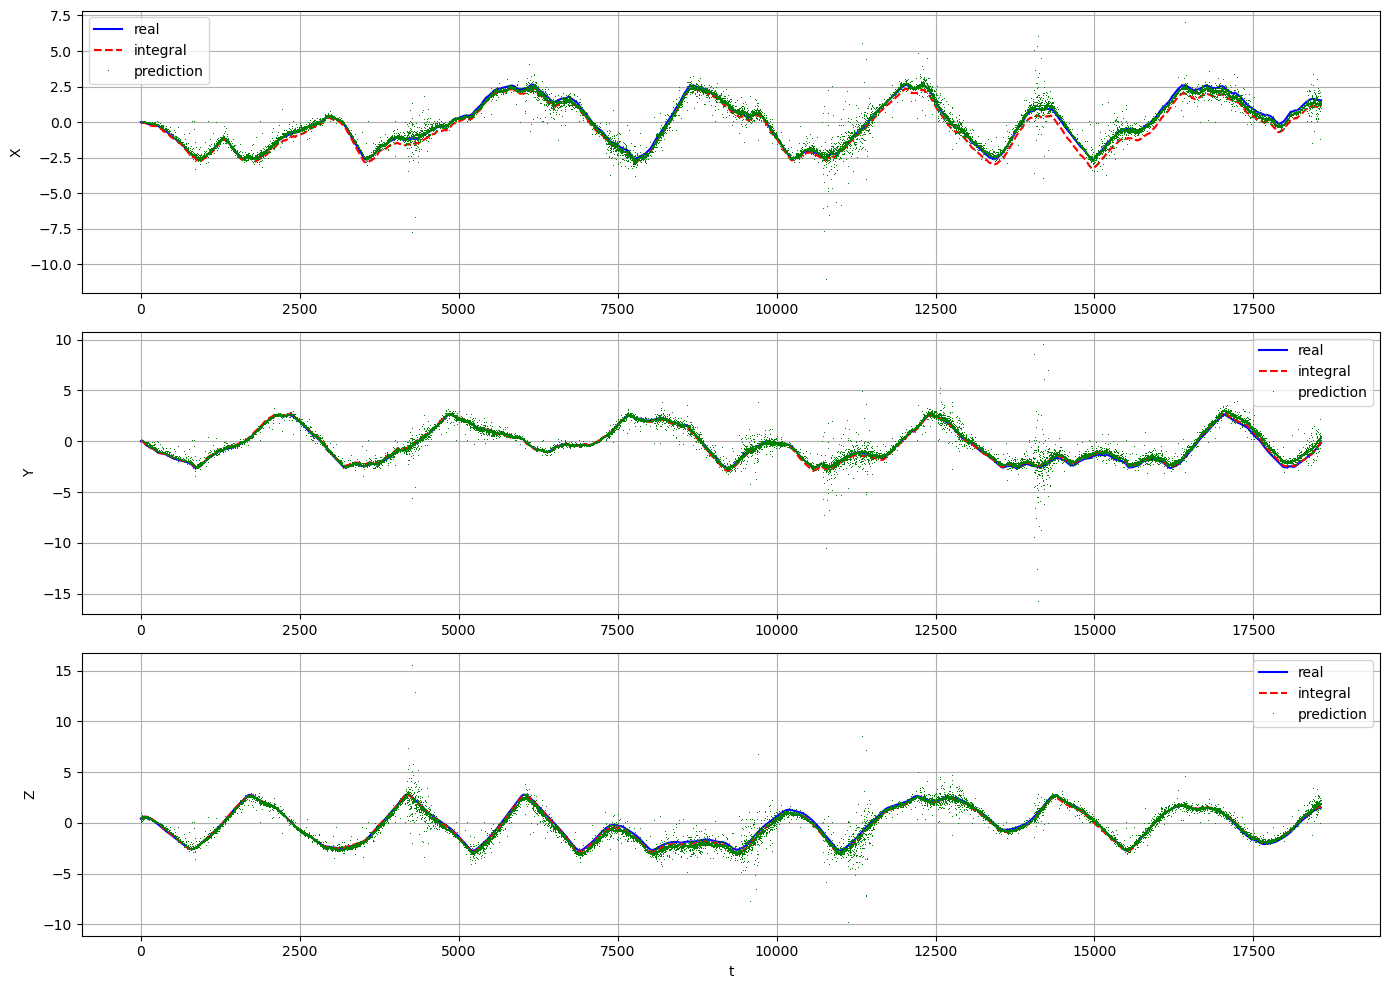

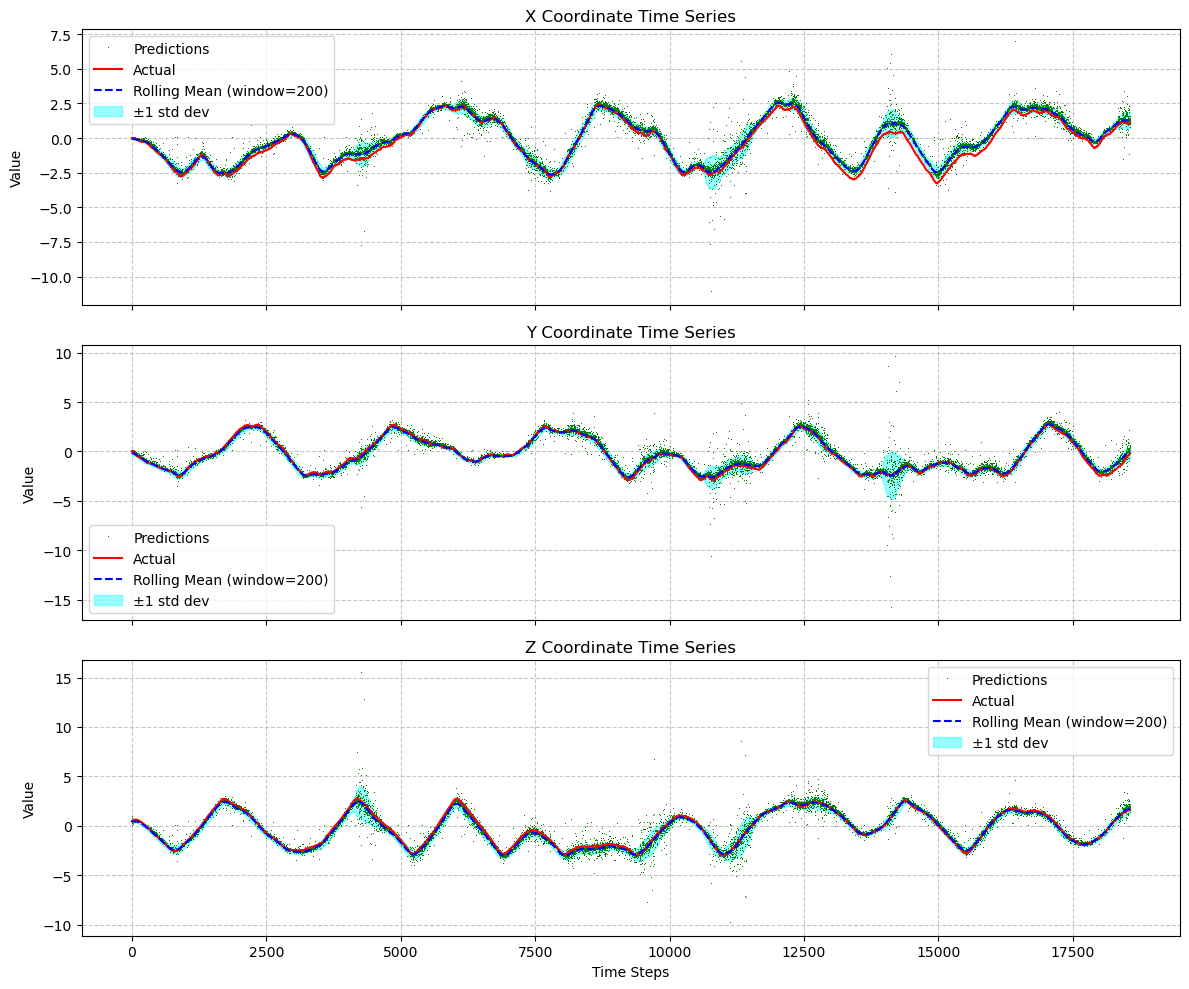

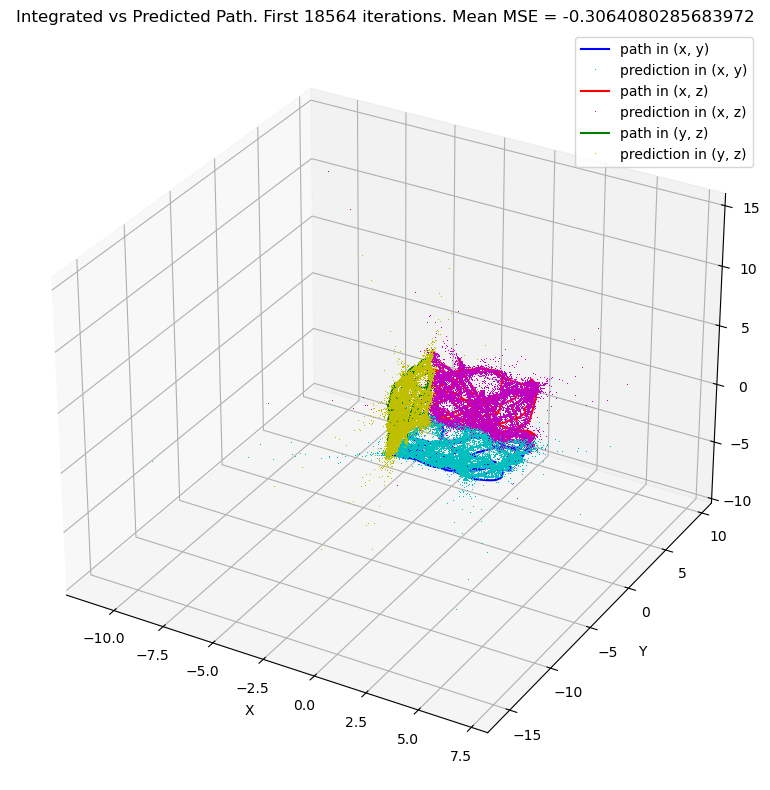

Distance matrix initialized
Distance matrix initialized
Initialised Mixed Modular Coder


  0%|          | 0/18564 [00:00<?, ?it/s]

using 3 gains with range 2.5 results: [0.2  1.35 2.5 ]
 mse_mean = -0.3056739201735652


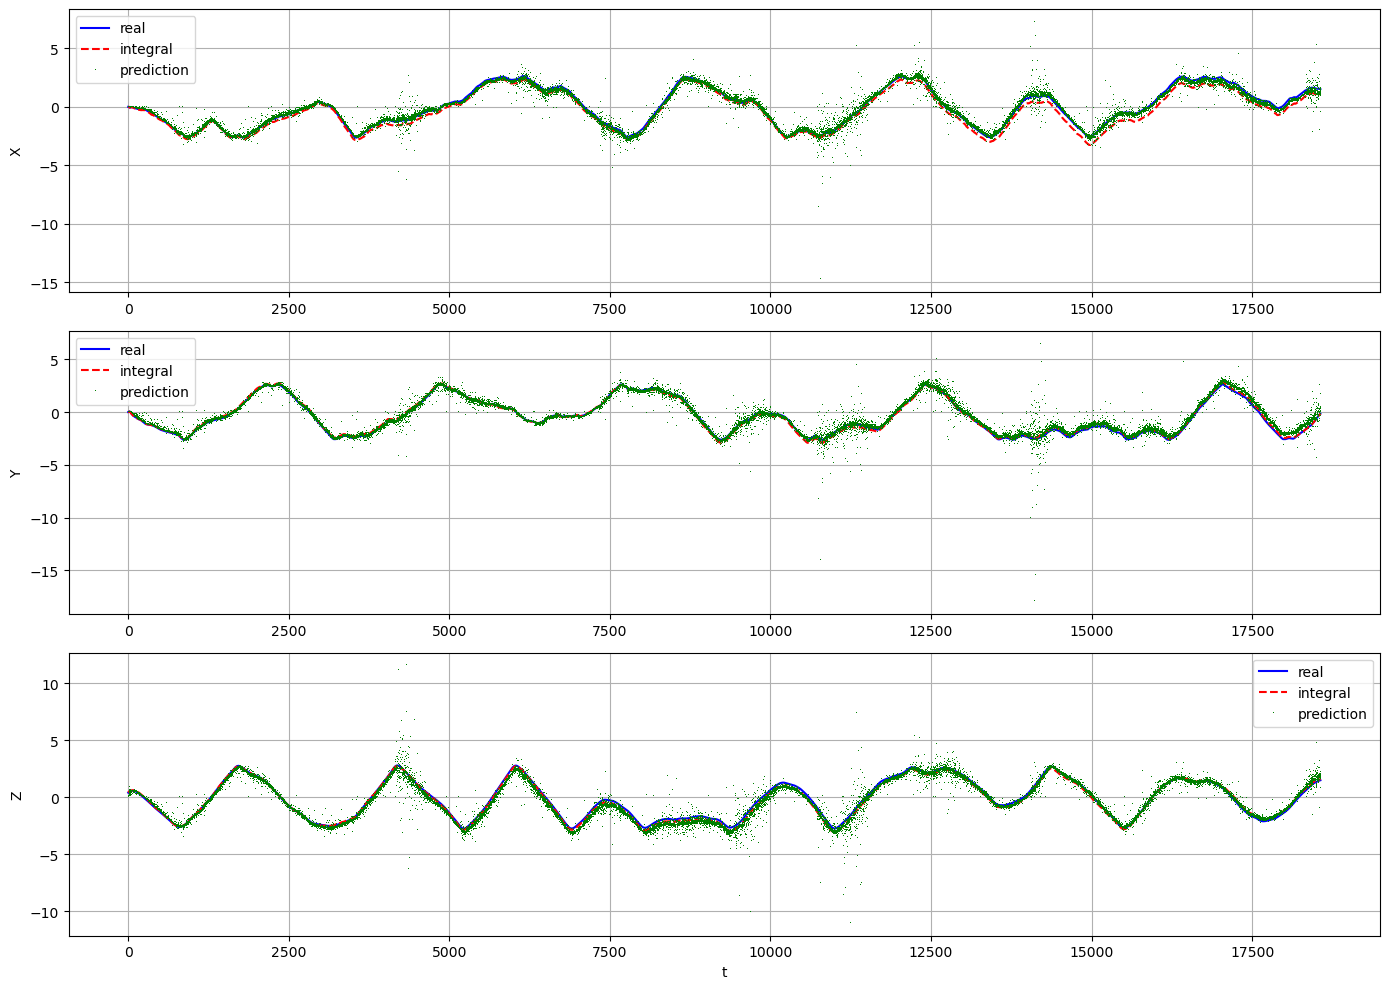

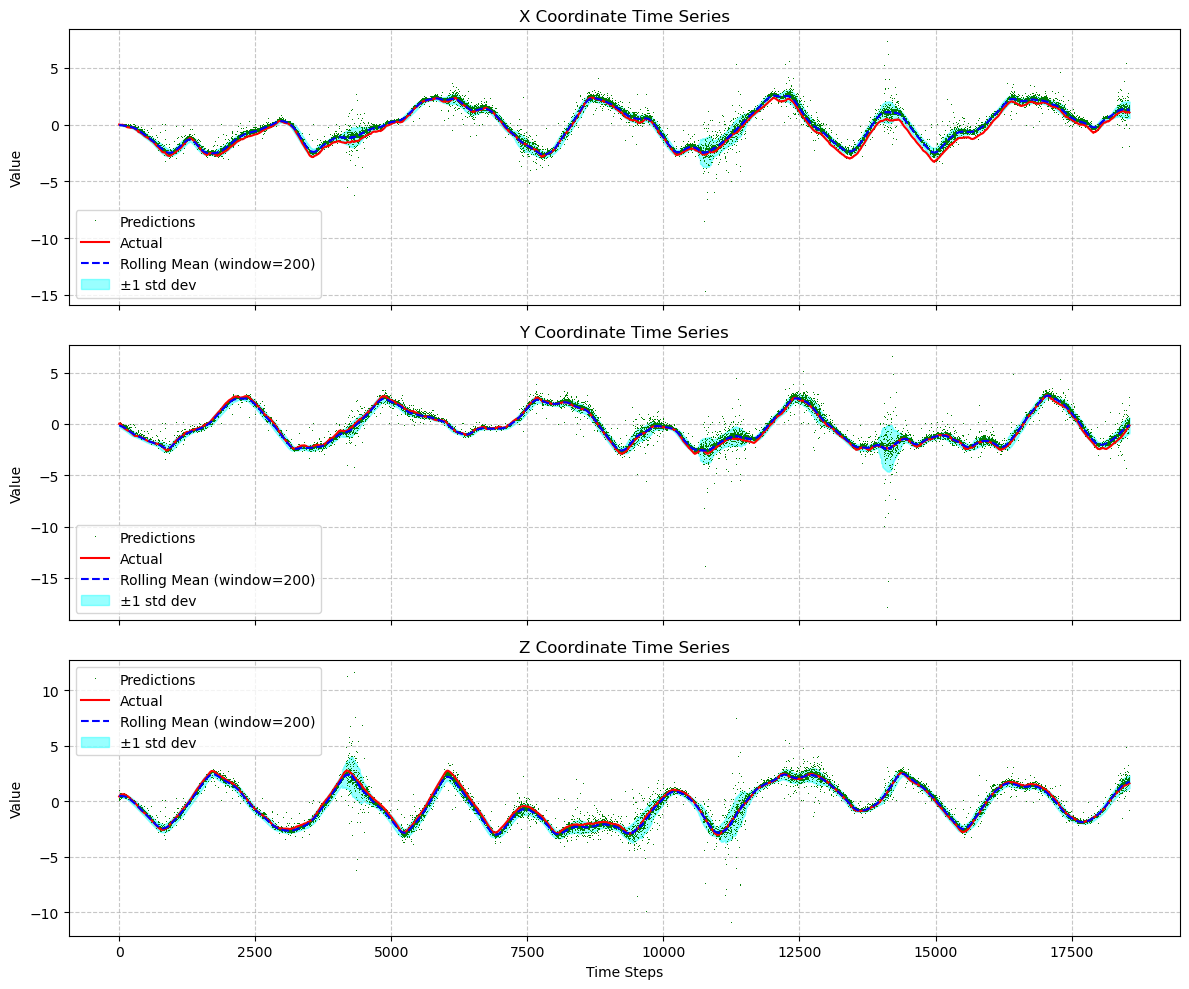

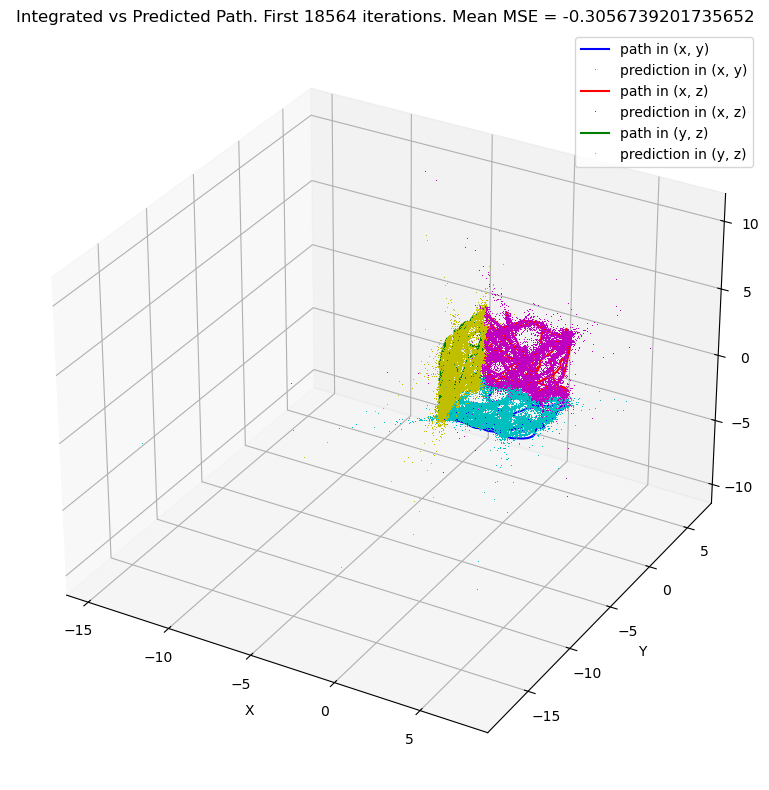

Distance matrix initialized
Distance matrix initialized
Initialised Mixed Modular Coder


  0%|          | 0/18564 [00:00<?, ?it/s]

using 3 gains with range 3.0 results: [0.2 1.6 3. ]
 mse_mean = -0.30570393829695386


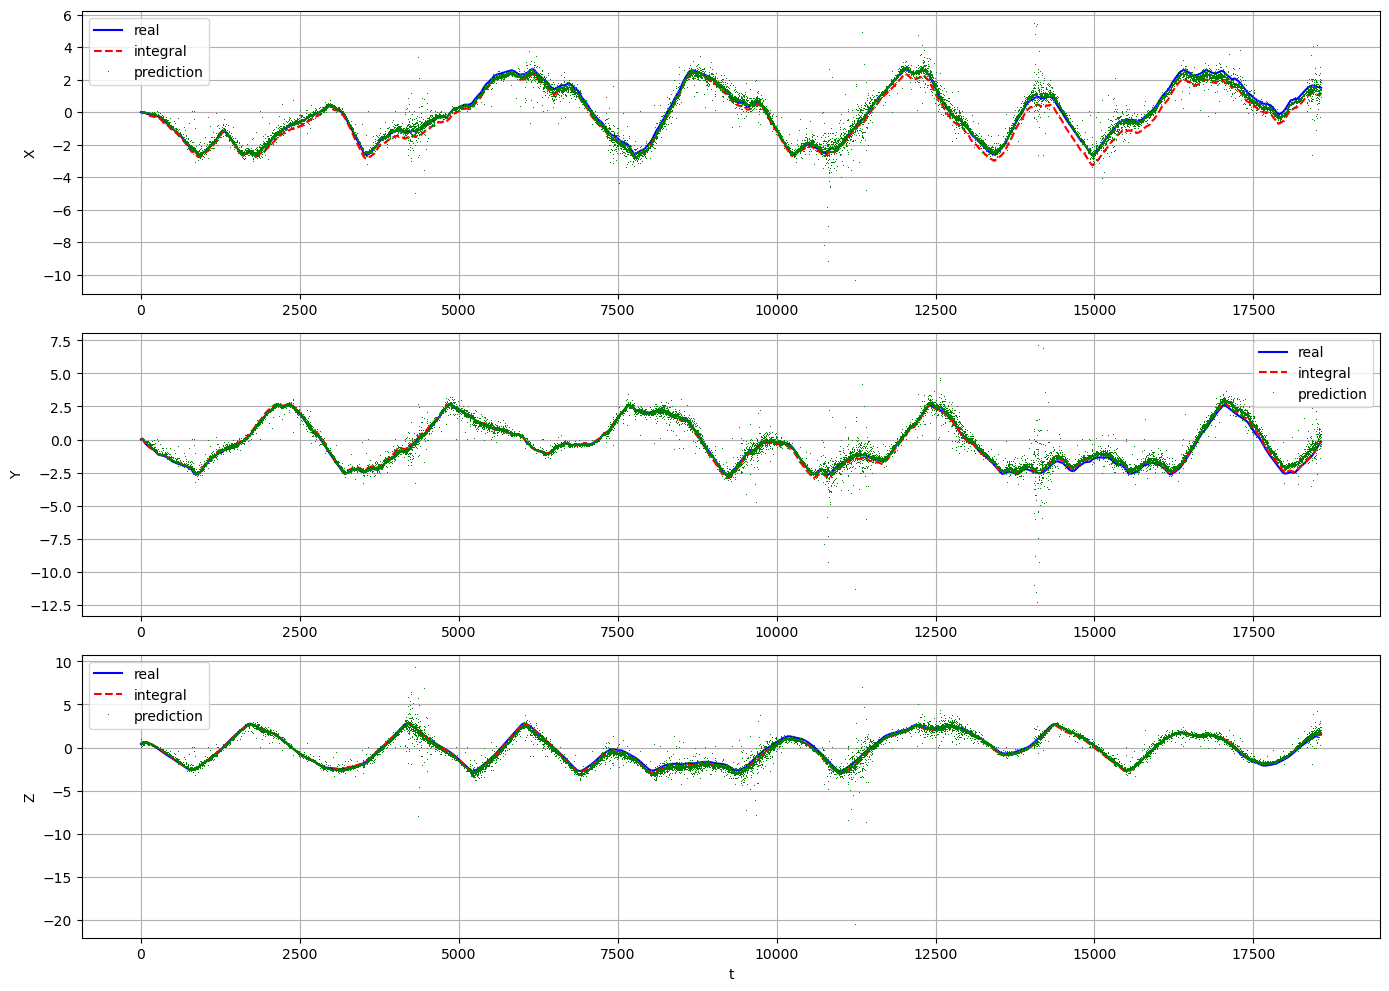

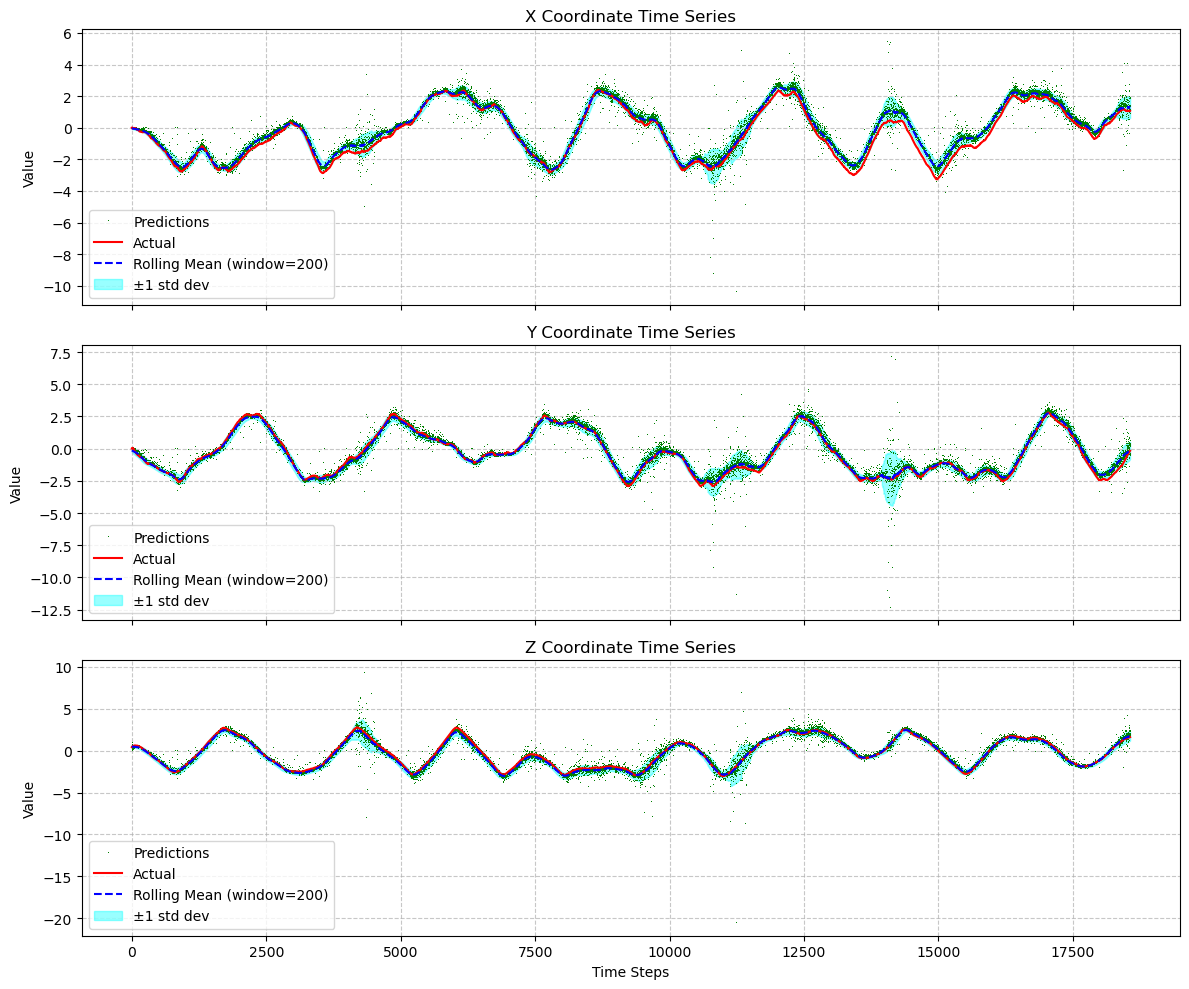

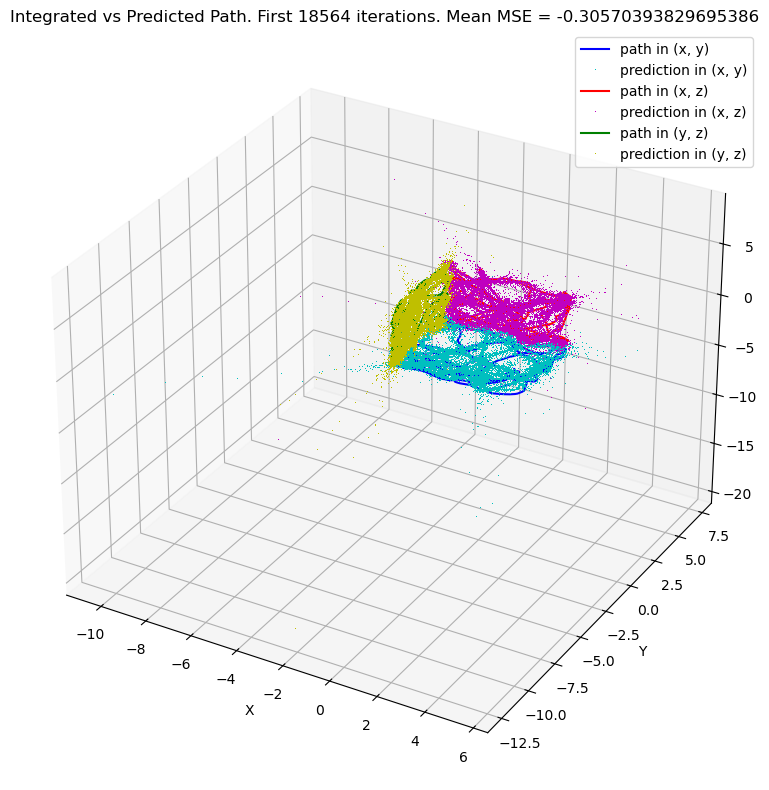

Distance matrix initialized
Distance matrix initialized
Initialised Mixed Modular Coder


  0%|          | 0/18564 [00:00<?, ?it/s]

using 4 gains with range 1.0 results: [0.2        0.46666667 0.73333333 1.        ]
 mse_mean = -0.30369744900830087


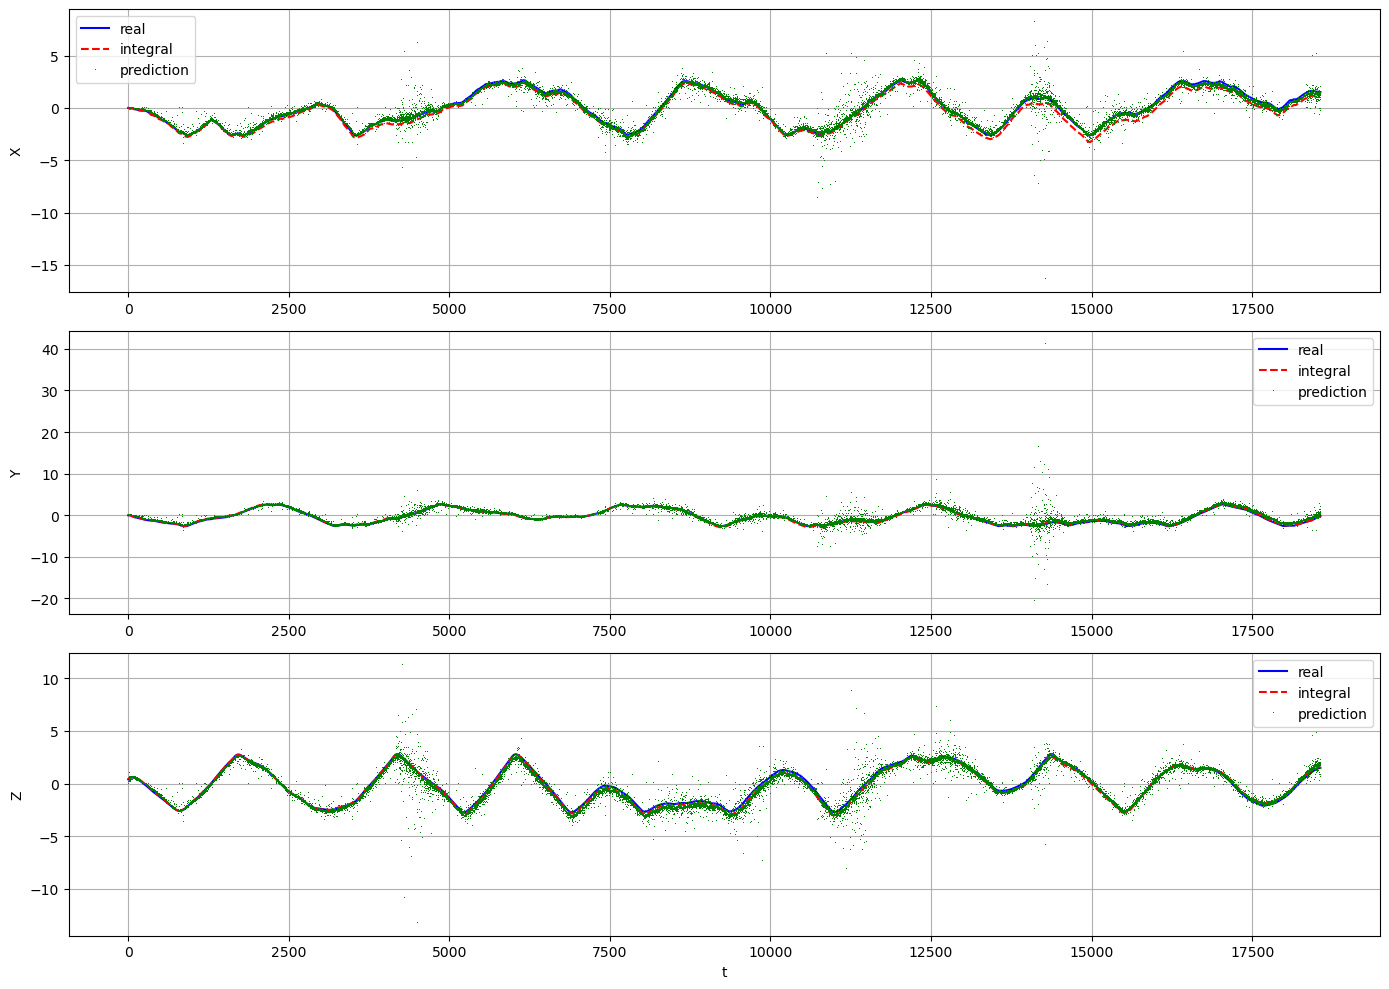

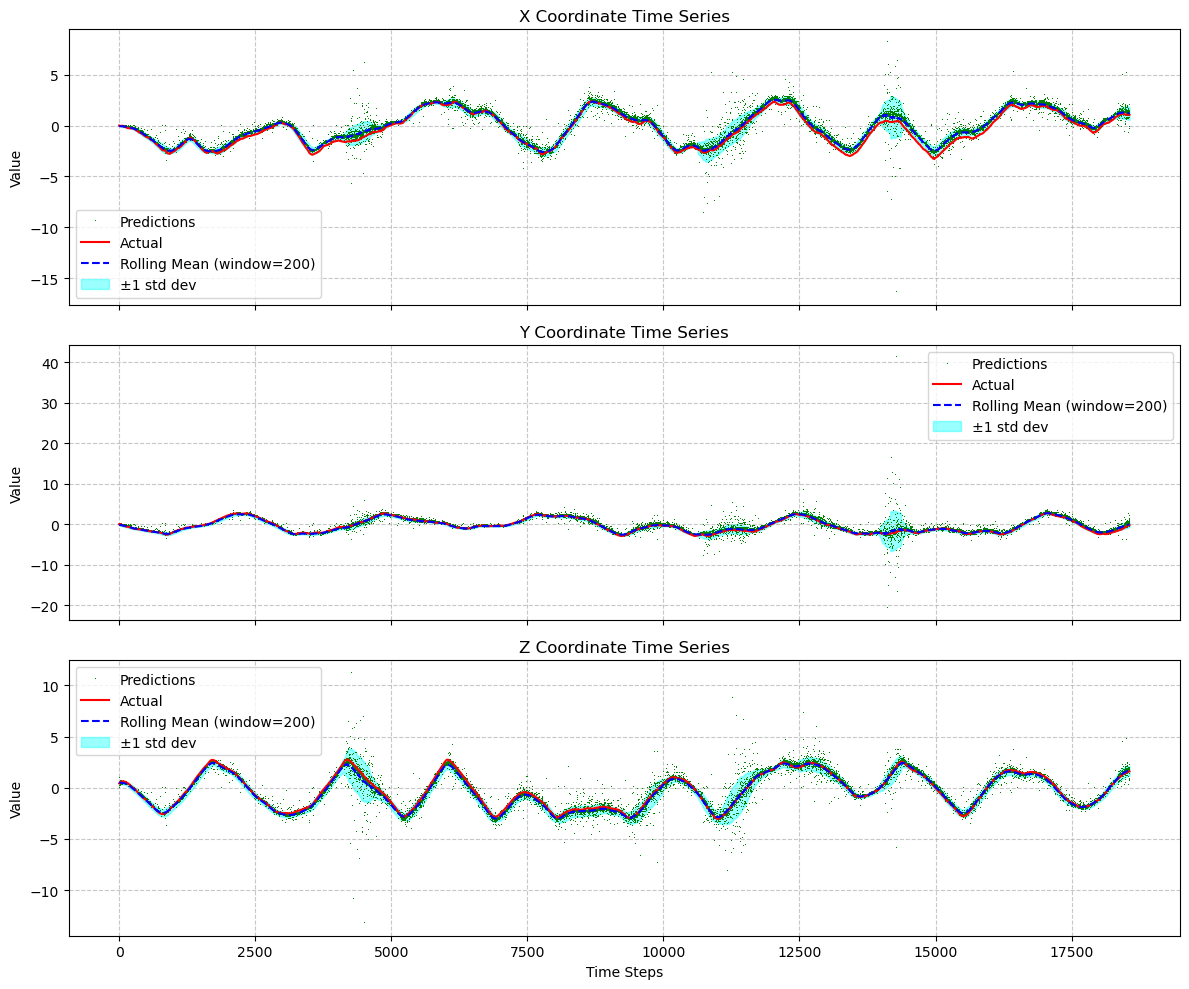

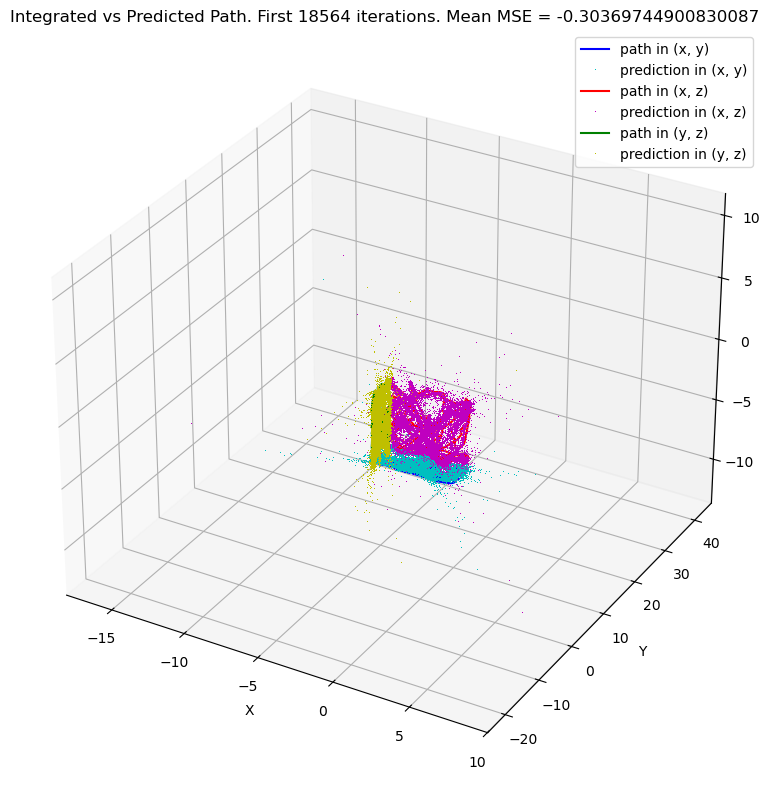

Distance matrix initialized
Distance matrix initialized
Initialised Mixed Modular Coder


  0%|          | 0/18564 [00:00<?, ?it/s]

using 4 gains with range 1.5 results: [0.2        0.63333333 1.06666667 1.5       ]
 mse_mean = -0.3044403739672229


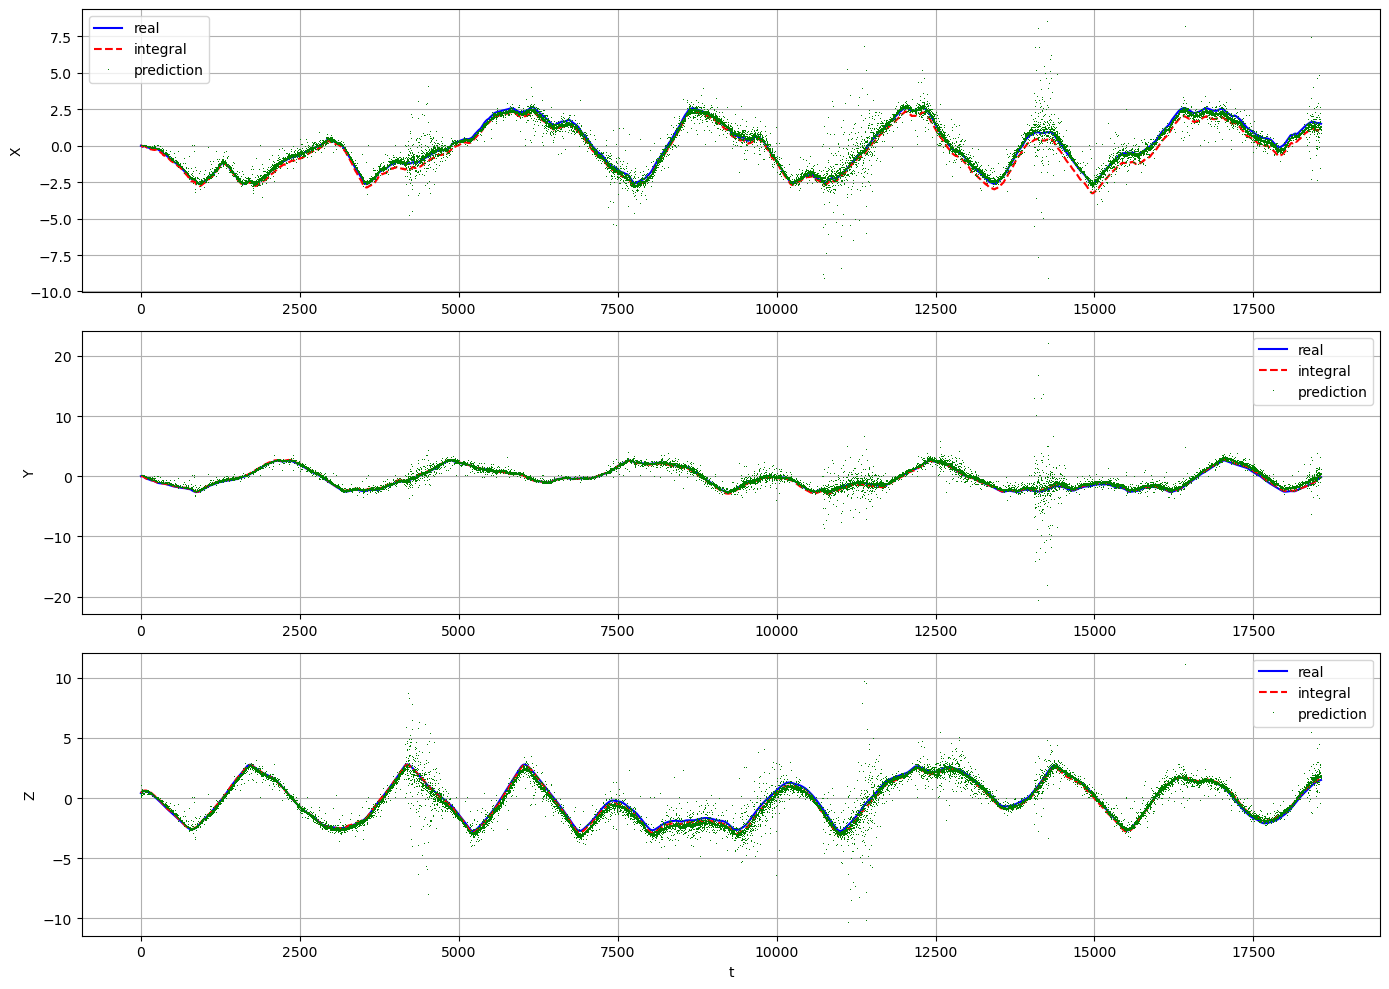

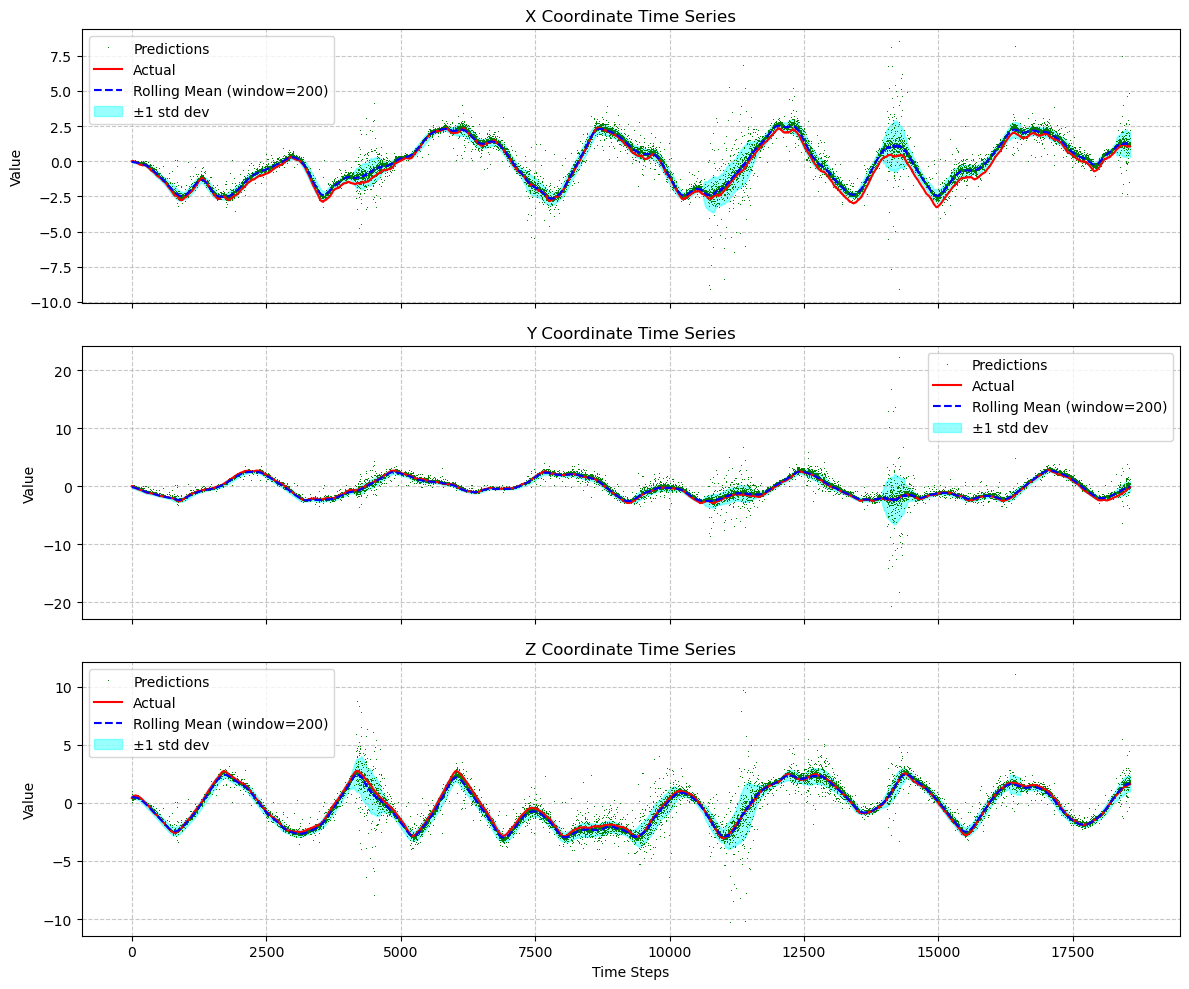

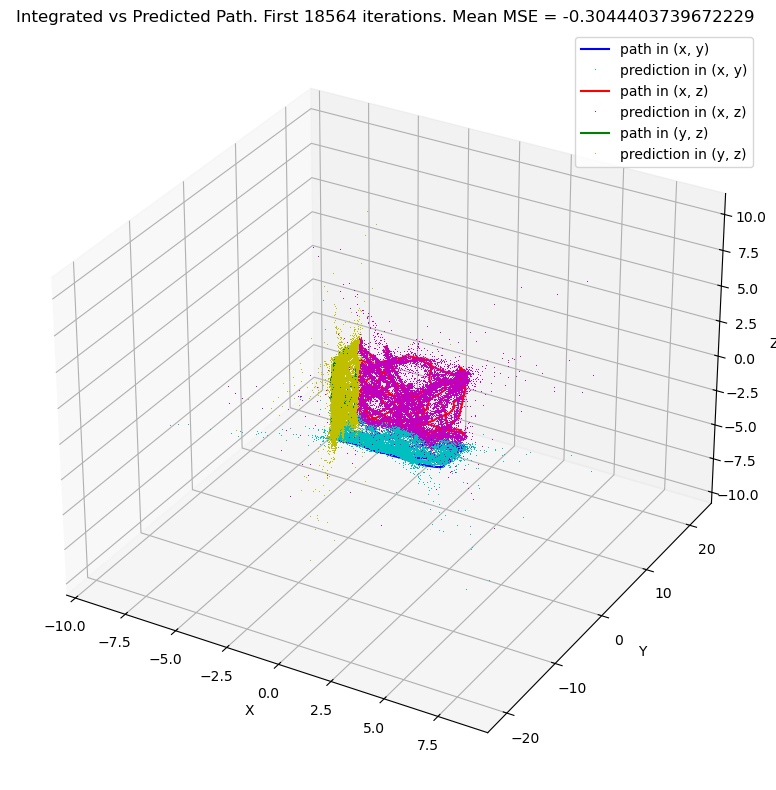

Distance matrix initialized
Distance matrix initialized
Initialised Mixed Modular Coder


  0%|          | 0/18564 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [72]:
from GridNetwork import MixedModularCoder
from PredictionModel import OptimisedRLS
from PredictionModel import fit_linear_model

dt = 32/1000

nr_gains = [3, 4, 5, 6, 7]
range_max = [1.0, 1.5, 2.0, 2.5, 3.0]
start = 0.2

mse = np.zeros((len(nr_gains), len(range_max)))

v_noise = np.random.normal(0, vn, (len(pos_r), 3)) # vec (t)
act_noise = np.random.normal(0, nn, (len(pos_r))) # scalar(t)

for i, nr in enumerate(nr_gains):
    for j, max_ in enumerate(range_max):       
        gains = np.linspace(start, max_, nr)
        mmc = MixedModularCoder(gains=gains)
        mmc.set_integrator(pos_r[0])
        rls = OptimisedRLS(mmc.ac_size, num_outputs=3)
        act_log = []
        pred_log = []
        error_log = []
        for t, v in enumerate(tqdm(vel)):
            act, pos = mmc.update((v+v_noise[t])*dt)
            act = np.clip(act + act_noise[t], 0.0, 1.0)
    
            act_log.append(act)

            pos_prediction = rls.predict(act)
            pos_error = (pos-pos_prediction)**2
            rls.update(act, pos)
            pred_log.append(pos_prediction)
            error_log.append(pos_error)
        #X, y, y_pred, mse_mean, mse_shuffeled, r2_mean, r2_shuffeled = fit_linear_model(np.array(act_log), pos_i, return_shuffled=True)
        mse[i,j] = np.mean(pred_log)
        y_pred = np.array(pred_log)
        
       #print(f'''using {nr} gains with range {max_} results: {gains}\n mse_mean = {mse_mean}\n mse_shuffeled = {mse_shuffeled}\nr2 = {r2_mean}\nr2_shuffeled = {r2_shuffeled}''')
        print(f'using {nr} gains with range {max_} results: {gains}\n mse_mean = {mse[i,j]}')
        XYZoverTime(pos_r, pos_i, pos_p=y_pred)
        plot_rolling_timeseries_stats(pos_i, y_pred)
        prediction_path_projected(pos_r, y_pred, mse[i,j], ID=ID)
        

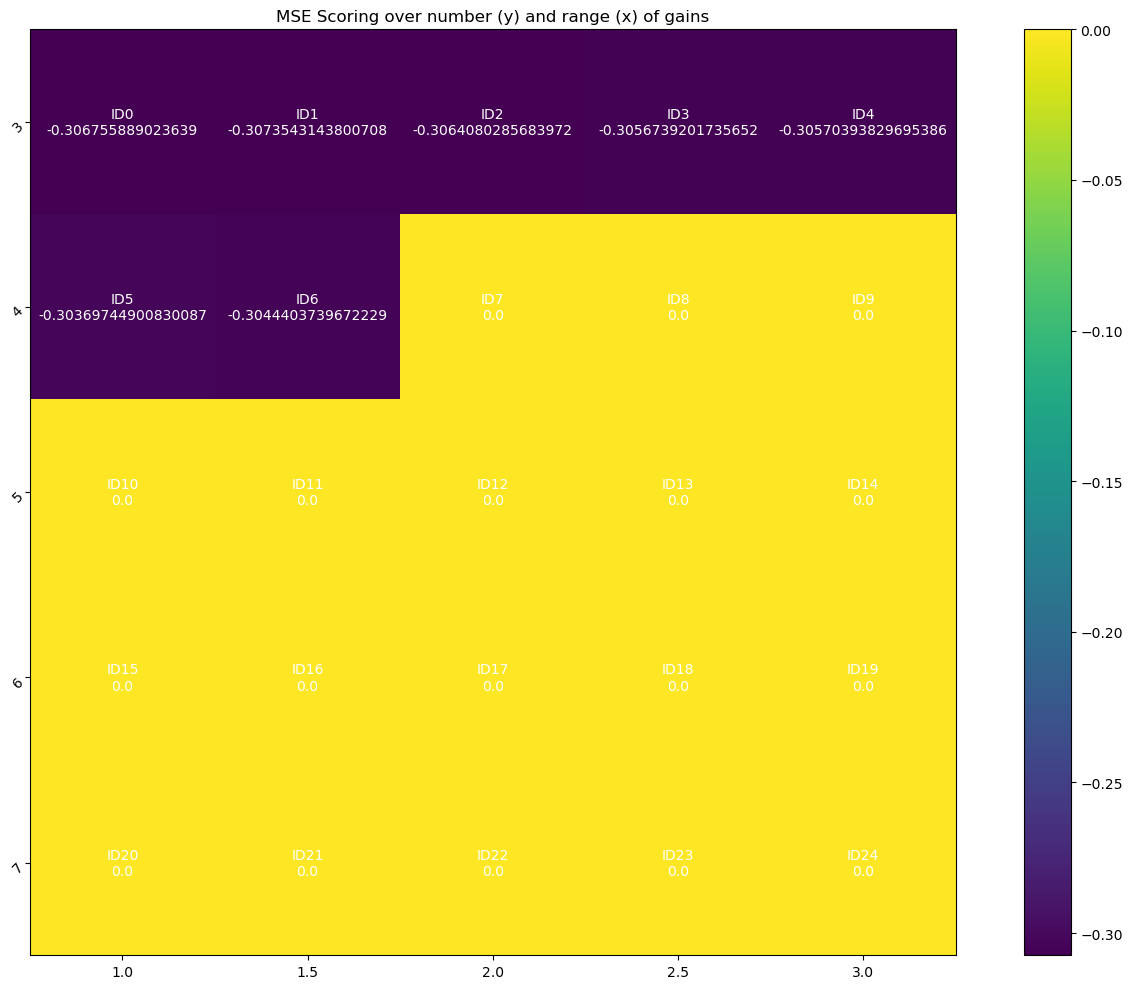

In [73]:
# nr_gains, range_max, mse

heatmap = np.array(mse).reshape((len(nr_gains), len(range_max)))
fig, ax = plt.subplots()
im = ax.imshow(heatmap)
ax.set_yticks(range(len(nr_gains)), labels=nr_gains,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_xticks(range(len(range_max)), labels=range_max)

for i in range(len(nr_gains)):
    for j in range(len(range_max)):
        text = ax.text(j, i, f'ID{j+(i*len(range_max))}\n{heatmap[i, j]}',
                       ha="center", va="center", color="w")

ax.set_title("MSE Scoring over number (y) and range (x) of gains")
fig.colorbar(im)
fig.tight_layout()
plt.savefig(f'Results\\best_gain_3D_results.png', format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
plt.show()
plt.close()

In [ ]:
from PredictionModel import fit_linear_model
X, y, y_pred, mse_mean, mse_shuffeled, r2_mean, r2_shuffeled = fit_linear_model(activity, pos_i, return_shuffled=True)
pos_p = y_pred

In [ ]:
print('pos real min, max:', np.min(pos_r), np.max(pos_r))
print('pos internal :', np.min(pos_i), np.max(pos_i))
print('pos predicted :', np.min(pos_p), np.max(pos_p))

In [ ]:
def pos_2d(pos, op=projection_operator):
    return np.einsum('myx, tx->mty', op, pos) # m = module, y = 3d, x = 2d, t = time

pos_r_2d = pos_2d(pos_r)
if online:
    pos_i_2d = pos_2d(pos_i)
    pos_p_2d = pos_2d(pos_p)

# Plot the results

In [ ]:
XYZoverTime()

In [ ]:
x, y, z = pos_r[:,0], pos_r[:,1], pos_r[:,2]
plt.plot(x, y, 'b:', label='xy path')
plt.plot(y, z, 'g:', label='yz path')
plt.plot(x, z, 'm:', label='xz path')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plot_3d_trajectory(pos_r, boundaries, ID=ID)

In [ ]:
plot_prediction_path_3d(pos_r, pos_i, pos_r, np.mean(mse_ar), ID=ID)
prediction_path_projected(pos_i, pos_p, mse_ar, ID=ID)
plot_modular_activity(projection_operator, pos_i, activity, gains, ID, projection)

## Plot Trajectory 

In [ ]:
def plot_3d_trajectory(pos, boundaries, ID='null'):
    x, y, z = pos[:,0], pos[:,1], pos[:,2]
    
    start = 0
    stop = int(len(x))#/5)
    #stop = np.clip(stop, 10, 40000)

    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(x[:stop], y[:stop], z[:stop], label='path')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    #plt.show()
    plt.savefig(f'Results\\ID {ID}\\3d_trajectory_spaceplot.png', format='png')
   # plt.close()

## Plot Prediction Path

In [ ]:
def plot_prediction_path_3d(path, path_in, path_pred, mse_mean, ID=0):
    stop = int(len(path)/5)
    stop = np.clip(stop, 10, 40000)
    # Unpack the actual and predicted coordinates
    x, y, z = path[:, 0], path[:, 1], path[:, 2]
    x_i, y_i, z_i = path_in[:, 0], path_in[:, 1], path_in[:, 2]
    x_pred, y_pred_val, z_pred = path_pred[:, 0], path_pred[:, 1], path_pred[:, 2]

    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual and predicted paths
    ax.plot(x[:stop], y[:stop], z[:stop], label='Actual path', color='blue')
    ax.plot(x_i[:stop], y_i[:stop], z_i[:stop], 'g:', label='path integrator')
    ax.plot(x_pred[:stop], y_pred_val[:stop], z_pred[:stop], 'r,', label='Predicted path')
    
    # Label axes, legend, and set title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Last {stop} iterations. Mean MSE = {mse_mean}')

    # End of simu
    plt.tight_layout()
    # Save and show the figure
    plt.savefig(f'Results\\ID {ID}\\predictionF.png', format='png')
    #plt.show()
    #plt.close()

    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual and predicted paths
    ax.plot(x[-stop:], y[-stop:], z[-stop:], label='Actual path', color='blue')
    ax.plot(x_i[-stop:], y_i[-stop:], z_i[-stop:], 'g:', label='path integrator')
    ax.plot(x_pred[-stop:], y_pred_val[-stop:], z_pred[-stop:], 'r,', label='Predicted path')
    
    # Label axes, legend, and set title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Last {stop} iterations. Mean MSE = {mse_mean}')

    plt.tight_layout()
    # Save and show the figure
    plt.savefig(f'Results\\ID {ID}\\predictionL.png', format='png')
    #plt.show()
    #plt.close()

def prediction_path_projected(path, path_pred, mse, ID=0):
    stop = int(len(path)/5)
    #stop = np.clip(stop, 10, 40000)
    
    x, y, z = path[:,0], path[:,1], path[:,2] 
    x_pred, y_pred, z_pred = path_pred[:,0], path_pred[:,1], path_pred[:,2] 
    x_min, y_min, z_min = np.min(x), np.max(y), np.min(z) # the y-axis is weird like that

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot x and y axes on z.
    ax.plot(x[:stop], y[:stop], 'b-', zs=z_min, zdir='z', label='path in (x, y)')
    ax.plot(x_pred[:stop], y_pred[:stop], 'c,', zs=z_min, zdir='z', label='prediction in (x, y)')
    
    ax.plot(x[:stop], z[:stop], 'r-', zs=y_min, zdir='y', label='path in (x, z)')
    ax.plot(x_pred[:stop], z_pred[:stop], 'm,' ,zs=y_min, zdir='y', label='prediction in (x, z)')
    
    ax.plot(y[:stop], z[:stop], 'g-', zs=x_min, zdir='x', label='path in (y, z)')
    ax.plot(y_pred[:stop], z_pred[:stop], 'y,', zs=x_min, zdir='x', label='prediction in (y, z)')

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Integrated vs Predicted Path. First {stop} iterations. Mean MSE = {np.mean(mse)}')
    
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #ax.view_init(elev=20., azim=-35, roll=0)
    plt.tight_layout()
    # Save and show the figure
    plt.show()
    plt.savefig(f'Results\\ID {ID}\\predictionProjected.png', format='png')
    plt.close()

## Plot Neural Activity

In [ ]:
def plot_frame_figure(gains, positions_array, network_activity, num_bins=50, neuron=42, ID=0, subID=None):
    """
    Plots a heatmap of network activity at different gain levels and overlays the trajectory. 
    The plot is saved in the results folder within the relative directory.

    :param positions_array: list of shape (ntime, ndim) 
    :param num_bins: int 
    :param network_activity: list of shape (ntime, ngain, nneuron)
    :param neuron: int. Default=42
    """
    x_min, y_min = np.min(positions_array, axis=0)
    x_max, y_max = np.max(positions_array, axis=0)

    fig = plt.figure(figsize=(13, 8))
    gs = fig.add_gridspec(2, len(gains)+1) 

    # Adding subplots to the gridspec
    for a, alpha in enumerate(gains):

        heatmap_ax = fig.add_subplot(gs[0, a])
        heatmap_ax.set_aspect('equal')

        # Initialize an empty heatmap
        x_bins = np.linspace(x_min, x_max,num_bins)
        y_bins = np.linspace(y_min, y_max,num_bins)
        heatmap = np.zeros((num_bins, num_bins))

        # Iterate over positions and network_activity (Over time)
        for position, activity in zip(positions_array, network_activity):
            x_index = np.digitize(position[0], x_bins) - 1
            y_index = np.digitize(position[1], y_bins) - 1
            heatmap[x_index, y_index] = max(heatmap[x_index, y_index], np.mean(activity[a, neuron]))
            #                                 Activity is of shape (ngains, neurons) here  ^^ pick any neuron

        im = heatmap_ax.imshow(heatmap.T, origin='lower', extent=[x_min, x_max, y_min, y_max], vmax=1, vmin=0)
        heatmap_ax.set(title=f'Gain = {round(alpha, 2)}', xticks=[], yticks=[])
        # add labels left plot
        if a == 0:
            heatmap_ax.set_xlabel('X axis arena')
            heatmap_ax.set_ylabel('Y axis arena')

    # # add subplot for colorbar (there is sth odd here, max fr is a bit above 1 and not 1)
    cbar_ax = fig.add_subplot(gs[0, -1])  # Spanning the last column
    colorbar = fig.colorbar(im, cax=cbar_ax)
    colorbar.set_label('Normalized firing rate', labelpad=15, rotation=270)
    colorbar.set_ticks([0, 0.5, 1])  # Set ticks at min, mid, and max values
    colorbar.set_ticklabels([f'{0:.2f}', f'{0.5:.2f}', f'{1:.2f}'])  # Set tick labels

    positions_array = np.array(positions_array) # enable numpy slicing      
    trajectory_ax = fig.add_subplot(gs[1, 1:len(gains)])  # Adding subplot for the bottom row
    trajectory_ax.plot(positions_array[:, 0], positions_array[:, 1], alpha=0.7, color='purple')
    trajectory_ax.set_title('Effective Arena with travelled path', fontsize=20)
    trajectory_ax.set_aspect('equal')


    fig.tight_layout(h_pad=3.0) # Adjust layout # change spacing between plots
    if subID is None:
        path = f'Results\\ID {ID}\\result_activity_figure.png'
    else:
        path = f'Results\\ID {ID}\\activity_{subID}.png'
    plt.savefig(path, format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
    #plt.show()
    #plt.close()

def plot_modular_activity(prj_op, pos, ac, gains, ID, projection):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    abc = np.array(['X', 'Y', 'Z'])
    for i, p in enumerate(pos2d):
        print(f'Projection in {abc[projection[i]]}')
        plot_frame_figure(gains, p, ac[:,i], ID=ID, subID=f'mod{i}')


## Produce Plots

In [ ]:
def XYZoverTime(pos_r, pos_i, pos_p):
    plt.rcParams["figure.figsize"] = (14,10)
    plt.subplot(3,1,1)
    plt.plot(pos_r[:,0], 'b-', label='real')
    plt.plot(pos_i[:,0], 'r--', label='integral')
    plt.plot(pos_p[:,0], 'g,', label='prediction')
    plt.legend()
    plt.ylabel('X')
    plt.grid()
    plt.subplot(3,1,2)
    plt.plot(pos_r[:,1], 'b-', label='real')
    plt.plot(pos_i[:,1], 'r--', label='integral')
    plt.plot(pos_p[:,1], 'g,', label='prediction')
    plt.legend()
    plt.ylabel('Y')
    plt.grid()
    plt.subplot(3,1,3)
    plt.plot(pos_r[:,2], 'b-', label='real')
    plt.plot(pos_i[:,2], 'r--', label='integral')
    plt.plot(pos_p[:,2], 'g,', label='prediction')
    plt.legend()
    plt.ylabel('Z')
    plt.xlabel('t')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
def generate_heatmap(x_min, x_max, y_min, y_max, num_bins, positions_array, network_activity, neuron=42):
    # Initialize an empty heatmap
    x_bins = np.linspace(x_min, x_max,num_bins)
    y_bins = np.linspace(y_min, y_max,num_bins)
    heatmap = np.zeros((num_bins, num_bins))

    # Iterate over positions and network_activity (Over time)
    for position, activity in zip(positions_array, network_activity):
        x_index = np.digitize(position[0], x_bins) - 1
        y_index = np.digitize(position[1], y_bins) - 1
        heatmap[x_index, y_index] = max(heatmap[x_index, y_index], np.mean(activity[a, neuron]))
        #                                 Activity is of shape (ngains, neurons) here  ^^ pick any neuron
    return heatmap

In [ ]:
def activity_heatmap_projected(gains, prj_op, pos, ac, num_bins=50, neuron=42, ID=0, subID=None):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    for i, p in enumerate(pos2d):
        plot_frame_figure(gains, p, ac[:,i], ID=ID, subID=f'mod{i}')
        
        x_min, y_min = np.min(positions_array, axis=0)
        x_max, y_max = np.max(positions_array, axis=0)

    fig = plt.figure(figsize=(13, 8))
    gs = fig.add_gridspec(2, len(gains)+1) 

    # Adding subplots to the gridspec
        for a, alpha in enumerate(gains):
            heatmap_ax = fig.add_subplot(gs[0, a])
            heatmap_ax.set_aspect('equal')
    
            heatmap = generate_heatmap(x_min, x_max, y_min, y_max, num_bins, pos, act)

        im = heatmap_ax.imshow(heatmap.T, origin='lower', extent=[x_min, x_max, y_min, y_max], vmax=1, vmin=0)
        heatmap_ax.set(title=f'Gain = {round(alpha, 2)}', xticks=[], yticks=[])
        # add labels left plot
        if a == 0:
            heatmap_ax.set_xlabel('X axis arena')
            heatmap_ax.set_ylabel('Y axis arena')

    # # add subplot for colorbar (there is sth odd here, max fr is a bit above 1 and not 1)
    cbar_ax = fig.add_subplot(gs[0, -1])  # Spanning the last column
    colorbar = fig.colorbar(im, cax=cbar_ax)
    colorbar.set_label('Normalized firing rate', labelpad=15, rotation=270)
    colorbar.set_ticks([0, 0.5, 1])  # Set ticks at min, mid, and max values
    colorbar.set_ticklabels([f'{0:.2f}', f'{0.5:.2f}', f'{1:.2f}'])  # Set tick labels

    positions_array = np.array(positions_array) # enable numpy slicing      
    trajectory_ax = fig.add_subplot(gs[1, 1:len(gains)])  # Adding subplot for the bottom row
    trajectory_ax.plot(positions_array[:, 0], positions_array[:, 1], alpha=0.7, color='purple')
    trajectory_ax.set_title('Effective Arena with travelled path', fontsize=20)
    trajectory_ax.set_aspect('equal')


    fig.tight_layout(h_pad=3.0) # Adjust layout # change spacing between plots
    if subID is None:
        path = f'Results\\ID{ID}\\result_activity_figure.png'
    else:
        path = f'Results\\ID{ID}\\activity_{subID}.png'
    plt.savefig(path, format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
    plt.show()
    plt.close()